# libs

In [3]:
import pymc3 as pm
import arviz as az

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import hashlib
import datetime
import warnings
import pickle
import gc

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns

In [6]:
from IPython.display import display

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [13, 7]

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import normalize, StandardScaler, LabelBinarizer
from sklearn.metrics         import classification_report, roc_curve, auc,accuracy_score, confusion_matrix, f1_score, fbeta_score
from sklearn.calibration     import CalibratedClassifierCV, calibration_curve
from boruta                  import BorutaPy

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier

import lightgbm as lgb         

In [9]:
import theano.tensor as tt

# testes

In [2]:
notas_1 = [61.1,61.1,60.3,61.0,60.9,60.6,60.0,59.8,59.4,59.6,59.6,59.5,59.6,59.1,59.1,58.9,58.9,59.1,59.5,59.2,59.5]

notas_2 = [61.10, 53.37, 66.08, 59.25, 57.98, 36.60, 51.80, 51.20, 68.20, 59.60, 55.00, 64.20, 35.60, 59.10, 49.10, 58.90, 70.10, 81.90, 42.10, 76.90]

In [ ]:
notas = notas_1

az.plot_kde(notas, rug=True)
plt.yticks([0], alpha=0);

with pm.Model() as model:
    p = pm.Normal('p', mu=71.8, sigma=1)
    data = pm.Normal('data', p, observed=notas)
    trace = pm.sample(return_inferencedata=True)

az.plot_posterior(trace, hdi_prob=0.66) ;

with pm.Model() as model_g:
#     μ = pm.Uniform('μ', lower=0, upper=90)
    μ = pm.Normal('μ', mu=71.8, sigma=10)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=notas)
    trace_g = pm.sample(1000, tune=1000)
    
az.plot_trace(trace_g);

az.plot_joint(trace_g, kind='kde', fill_last=False);

print( az.summary(trace_g) )

az.plot_posterior(trace_g);

ppc = pm.sample_posterior_predictive(trace_g, samples=15000, model=model_g)
np.asarray(ppc['y']).shape

_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(np.mean(notas))

y_pred_g = pm.sample_posterior_predictive(trace_g, samples=100, model=model_g)
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax.legend(fontsize=15)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.884276104032208, but should be close to 0.8. Try to increase the number of tuning steps.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  58.917  2.738  53.700   63.895      0.053    0.037    2728.0    2490.0   
σ  12.232  2.019   8.802   15.919      0.039    0.028    2979.0    2621.0   

   r_hat  
μ    1.0  
σ    1.0  


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


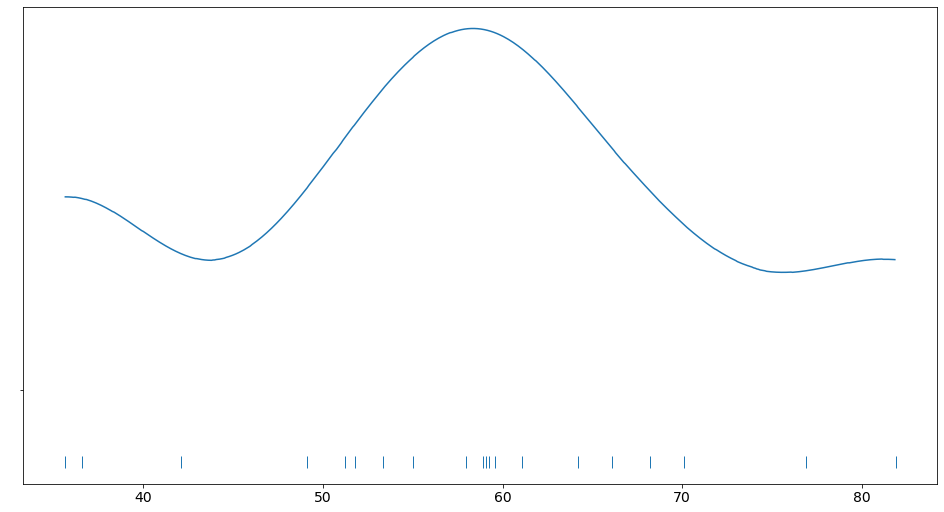

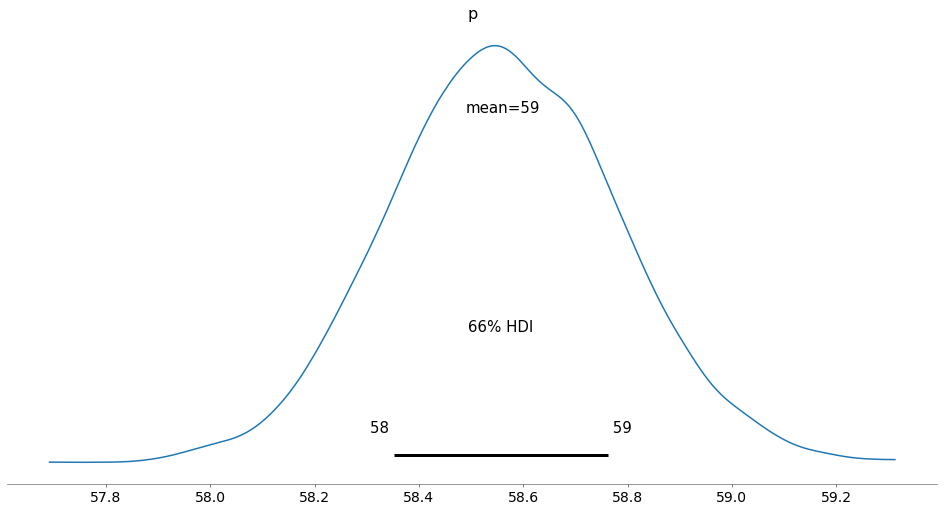

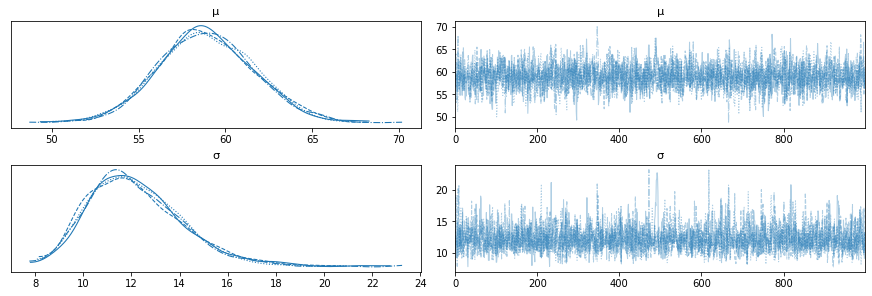

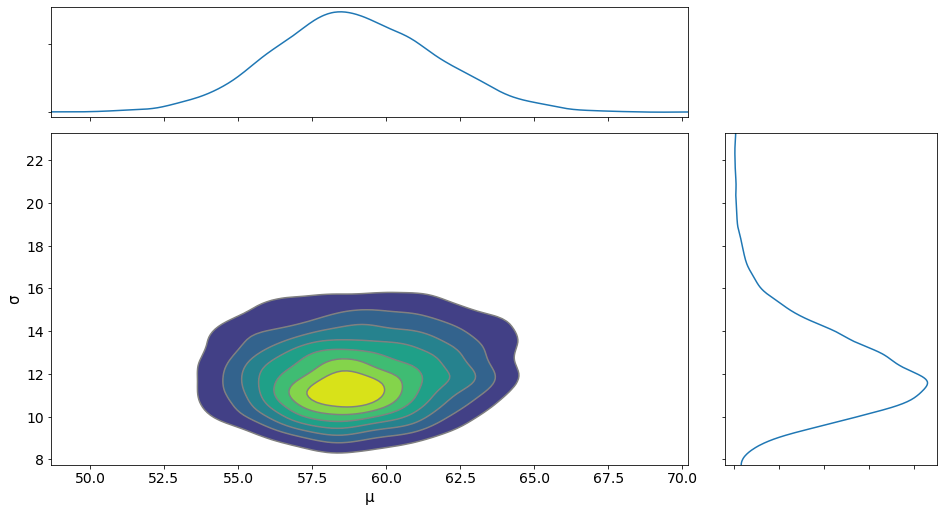

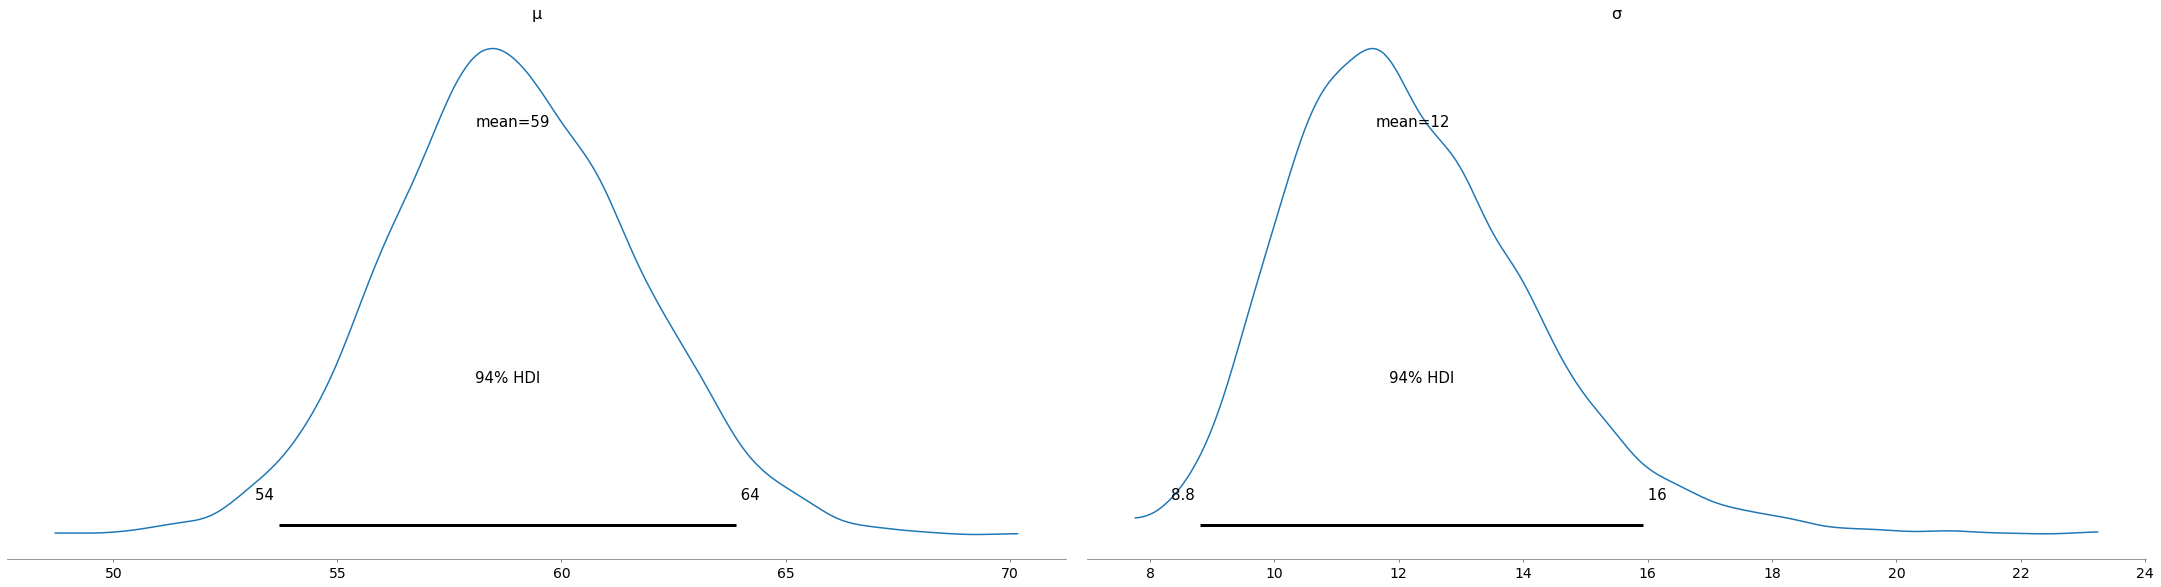

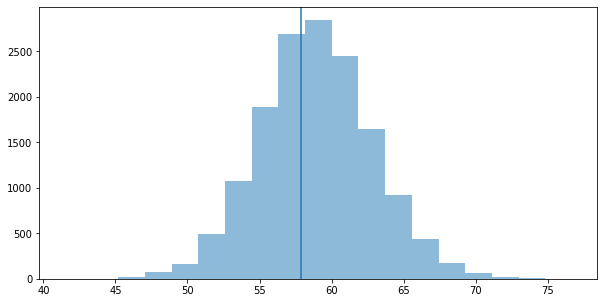

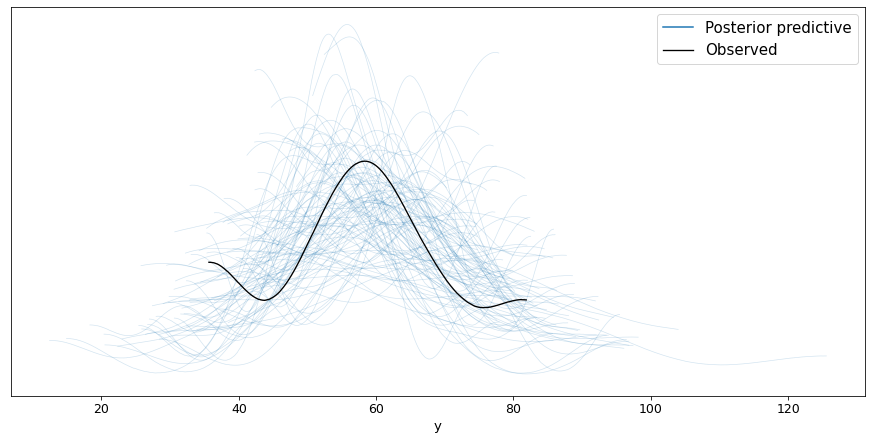

In [112]:
notas = notas_2

az.plot_kde(notas, rug=True)
plt.yticks([0], alpha=0);

with pm.Model() as model:
    p = pm.Normal('p', mu=71.8, sigma=1)
    data = pm.Normal('data', p, observed=notas)
    trace = pm.sample(return_inferencedata=True)

az.plot_posterior(trace, hdi_prob=0.66) ;

with pm.Model() as model_g:
#     μ = pm.Uniform('μ', lower=0, upper=90)
    μ = pm.Normal('μ', mu=71.8, sigma=10)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=notas)
    trace_g = pm.sample(1000, tune=1000)
    
az.plot_trace(trace_g);

az.plot_joint(trace_g, kind='kde', fill_last=False);

print( az.summary(trace_g) )

az.plot_posterior(trace_g);

ppc = pm.sample_posterior_predictive(trace_g, samples=15000, model=model_g)
np.asarray(ppc['y']).shape

_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(np.mean(notas))

y_pred_g = pm.sample_posterior_predictive(trace_g, samples=100, model=model_g)
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax.legend(fontsize=15)

# classificador binário

In [40]:
df = pd.read_csv('~/Documents/data/cartola-fc-brasil-scouts/jogadores.csv')

df = df.sort_values(by=["ano", "rodada"]).copy()
df['id']  = df['Nome'].apply( lambda x: hashlib.sha1(str.encode(x)).hexdigest() )
df['pos'] = df['Nome'].apply( lambda x: x.split('(')[-1].split(')')[0].strip() )

# df["G"] = df["G"].fillna(0).diff()
# df["A"] = df["A"].fillna(0).diff()

# df = df.query("(A >= 0 & G >= 0)").copy()

# display( df.sort_values(by="Nome") )
display( df )

scouts  = ['DS','G','A','SG','FS','FF','FD','FT','DD','DP','GC','CV','CA','PP','GS','FC','I','PI','RB','PE']
mercado = ['Preço', 'Média','Variação']
keys    = ["id", "ano"]

gscouts = df.groupby(keys)[scouts].agg(['max'])
gscouts.columns = gscouts.columns.map('_'.join)
gscouts = gscouts.reset_index()

gmercado = df.groupby(keys)[mercado].agg(['max'])
gmercado.columns = gmercado.columns.map('_'.join)
gmercado = gmercado.reset_index()

gpos = df.groupby(keys)[['pos']].agg(['first'])
gpos.columns = gpos.columns.map('_'.join)
gpos = gpos.reset_index()

print("gscouts")
display(gscouts.sample(5))
print("gmercado")
display(gmercado.sample(5))
print("gpos")
display(gpos.sample(5))

display(gpos['pos_first'].value_counts())

Nome         Clube  Preço    J  Média  Últ. Pont.  \
7882     Ricardo Bueno (ATA)         Ceará  18.52  1.0  22.70        22.7   
7883    Bruno Henrique (ATA)      Flamengo  21.51  1.0  21.00        21.0   
7884             Nikão (MEI)  Athlético-PR  19.29  1.0  18.80        18.8   
7885             Tiepo (GOL)   Chapecoense  13.18  1.0  17.00        17.0   
7886         Vanderlei (GOL)        Santos  22.69  1.0  15.70        15.7   
...                      ...           ...    ...  ...    ...         ...   
7877            Jadson (MEI)  Athlético-PR   3.53  9.0   0.11         0.8   
7878  Patrick de Lucca (MEI)         Bahia   0.77  3.0  -0.23        -1.5   
7879    Guilherme Biro (ATA)      Coritiba   0.77  8.0  -0.32        -3.6   
7880   Gabriel Pereira (MEI)   Corinthians   0.79  5.0  -0.40         0.0   
7881        Wellington (LAT)     São Paulo   0.77  1.0  -3.10        -3.1   

      Variação    DS    G    A  ...   GS    FC    I    PI  rodada   ano   RB  \
7882     14.52   NaN  2.0  1.0  ...  NaN   2.0  1.0   NaN       1  2019  1.0   
7883     11.51   NaN  2.0  NaN  ...  NaN   1.0  NaN   NaN       1  2019  NaN   
7884     10.29   NaN  1.0  NaN  ...  NaN   1.0  NaN   NaN       1  2019  5.0   
7885     11.18   NaN  NaN  NaN  ...  NaN   NaN  NaN   NaN       1  2019  NaN   
7886      5.69   NaN  NaN  NaN  ...  1.0   NaN  NaN   NaN       1  2019  NaN   
...        ...   ...  ...  ...  ...  ...   ...  ...   ...     ...   ...  ...   
7877     -0.40   NaN  NaN  NaN  ...  NaN   3.0  NaN  40.0      38  2020  NaN   
7878     -0.29   1.0  NaN  NaN  ...  NaN   NaN  NaN  25.0      38  2020  NaN   
7879     -0.21  15.0  NaN  NaN  ...  NaN  14.0  NaN  41.0      38  2020  NaN   
7880      0.00   1.0  NaN  NaN  ...  NaN   6.0  NaN  15.0      38  2020  NaN   
7881     -0.23   NaN  NaN  NaN  ...  NaN   4.0  NaN   1.0      38  2020  NaN   

       PE                                        id  pos  
7882  1.0  1f4d452190fb0558c5f5696b944b9afe4b02ca08  ATA  
7883  NaN  9f9a076464350d81d76c9b8940d64b9890e4b053  ATA  
7884  NaN  9752a812f300239c0f4fcae95d41e2843653a308  MEI  
7885  NaN  ec9799d86e28ec368cccfb660bf39ff3bc3eed7c  GOL  
7886  1.0  a5dde5accc0044a9808b0257f6faa5ba89342b7f  GOL  
...   ...                                       ...  ...  
7877  NaN  fe95e28e44efa7db07376c045a2fa89332ea5308  MEI  
7878  NaN  0157594398527348fc28f663c44291f22f8172ae  MEI  
7879  NaN  3e299fb9c705d57573fa4ab8a1a9f607edc60dc2  ATA  
7880  NaN  90a8b33c4ac288f85fa4a7e678592dd30600d8a4  MEI  
7881  NaN  e56896e9bd7426de5236ee5280c369328818c6c3  LAT  

[16404 rows x 31 columns]

gscouts


id   ano  DS_max  G_max  A_max  \
484  5f42fe02c02ff9b43d724266df09708833cc8f71  2019     NaN    1.0    NaN   
877  ae894c371e565521fc685e1aaafcbaed39960334  2019     NaN    NaN    NaN   
115  1244ecf38d0346dea47819aecd310e0e835d99fd  2019     NaN    NaN    NaN   
703  8e8e0983e4fb4a9729ba14044d9f60b30b3d7bb3  2020    54.0    3.0    3.0   
415  50b889364bb14da9383cea7fe881a43ec0917d36  2019     NaN    NaN    NaN   

     SG_max  FS_max  FF_max  FD_max  FT_max  ...  GC_max  CV_max  CA_max  \
484     NaN    10.0     4.0     1.0     NaN  ...     NaN     NaN     3.0   
877     3.0     1.0     1.0     NaN     NaN  ...     NaN     NaN     1.0   
115     NaN     NaN     NaN     NaN     NaN  ...     NaN     NaN     NaN   
703    13.0    14.0    10.0     6.0     NaN  ...     NaN     NaN     4.0   
415     2.0     NaN     1.0     NaN     NaN  ...     NaN     NaN     NaN   

     PP_max  GS_max  FC_max  I_max  PI_max  RB_max  PE_max  
484     NaN     NaN    15.0    NaN     NaN    15.0    15.0  
877     NaN     NaN     5.0    NaN     NaN     9.0    10.0  
115     NaN     NaN     NaN    NaN     NaN     NaN     NaN  
703     NaN     NaN    40.0    1.0   292.0     NaN     NaN  
415     NaN     NaN     NaN    NaN     NaN     3.0     5.0  

[5 rows x 22 columns]

gmercado


id   ano  Preço_max  Média_max  \
1071  d7d512fb54cabe1a859c82ade302644b3ccc9cfc  2020       2.42       0.62   
420   51a61be54c08748ef400070ece4a762fb2e59785  2019       5.09       2.10   
978   c5676639b11f64a4d5406008f1d88406ca66671f  2020       3.20       2.30   
763   9a72cb78796437f0a90ca7397d0a1f76bd0d4fe8  2019       6.26       4.90   
1273  fe95e28e44efa7db07376c045a2fa89332ea5308  2020       3.93       0.75   

      Variação_max  
1071          0.48  
420           0.74  
978           1.35  
763           2.80  
1273          0.58

gpos


id   ano pos_first
261   2febd8e308db20cc9c66afe4baae62f6101e40ad  2020       LAT
587   74edff992f814c5bdfc3637d754e9d2fa2b130bd  2020       MEI
1242  f869d279aa36618f697d3c2eda2d1aa849beea66  2020       GOL
642   7edd3a734e920b827d6ae5797504ba3e59e452d2  2019       TEC
820   a5e1ff862242bdb9e61e6f6860c1ae461e968405  2019       GOL

MEI    408
ATA    285
ZAG    203
LAT    200
GOL     96
TEC     91
Name: pos_first, dtype: int64

In [72]:
cols_ = ["Preço_max", "Média_max", "Variação_max", "G_max", "A_max", "I_max", "GC_max", "FC_max", "pos_first"]
X = pd.concat([gscouts.drop(columns=keys), gmercado.drop(columns=keys), gpos.drop(columns=keys)], axis=1).copy().fillna(-1.0)[cols_]
X.columns = X.columns.str.upper()

In [73]:
scaler = StandardScaler()
scaler = MinMaxScaler()

yy = 1 * X["POS_FIRST"] == "ATA"
xx = scaler.fit_transform( X.drop(columns=["POS_FIRST"]) )

In [74]:
yy.value_counts().sort_index()

False    998
True     285
Name: POS_FIRST, dtype: int64

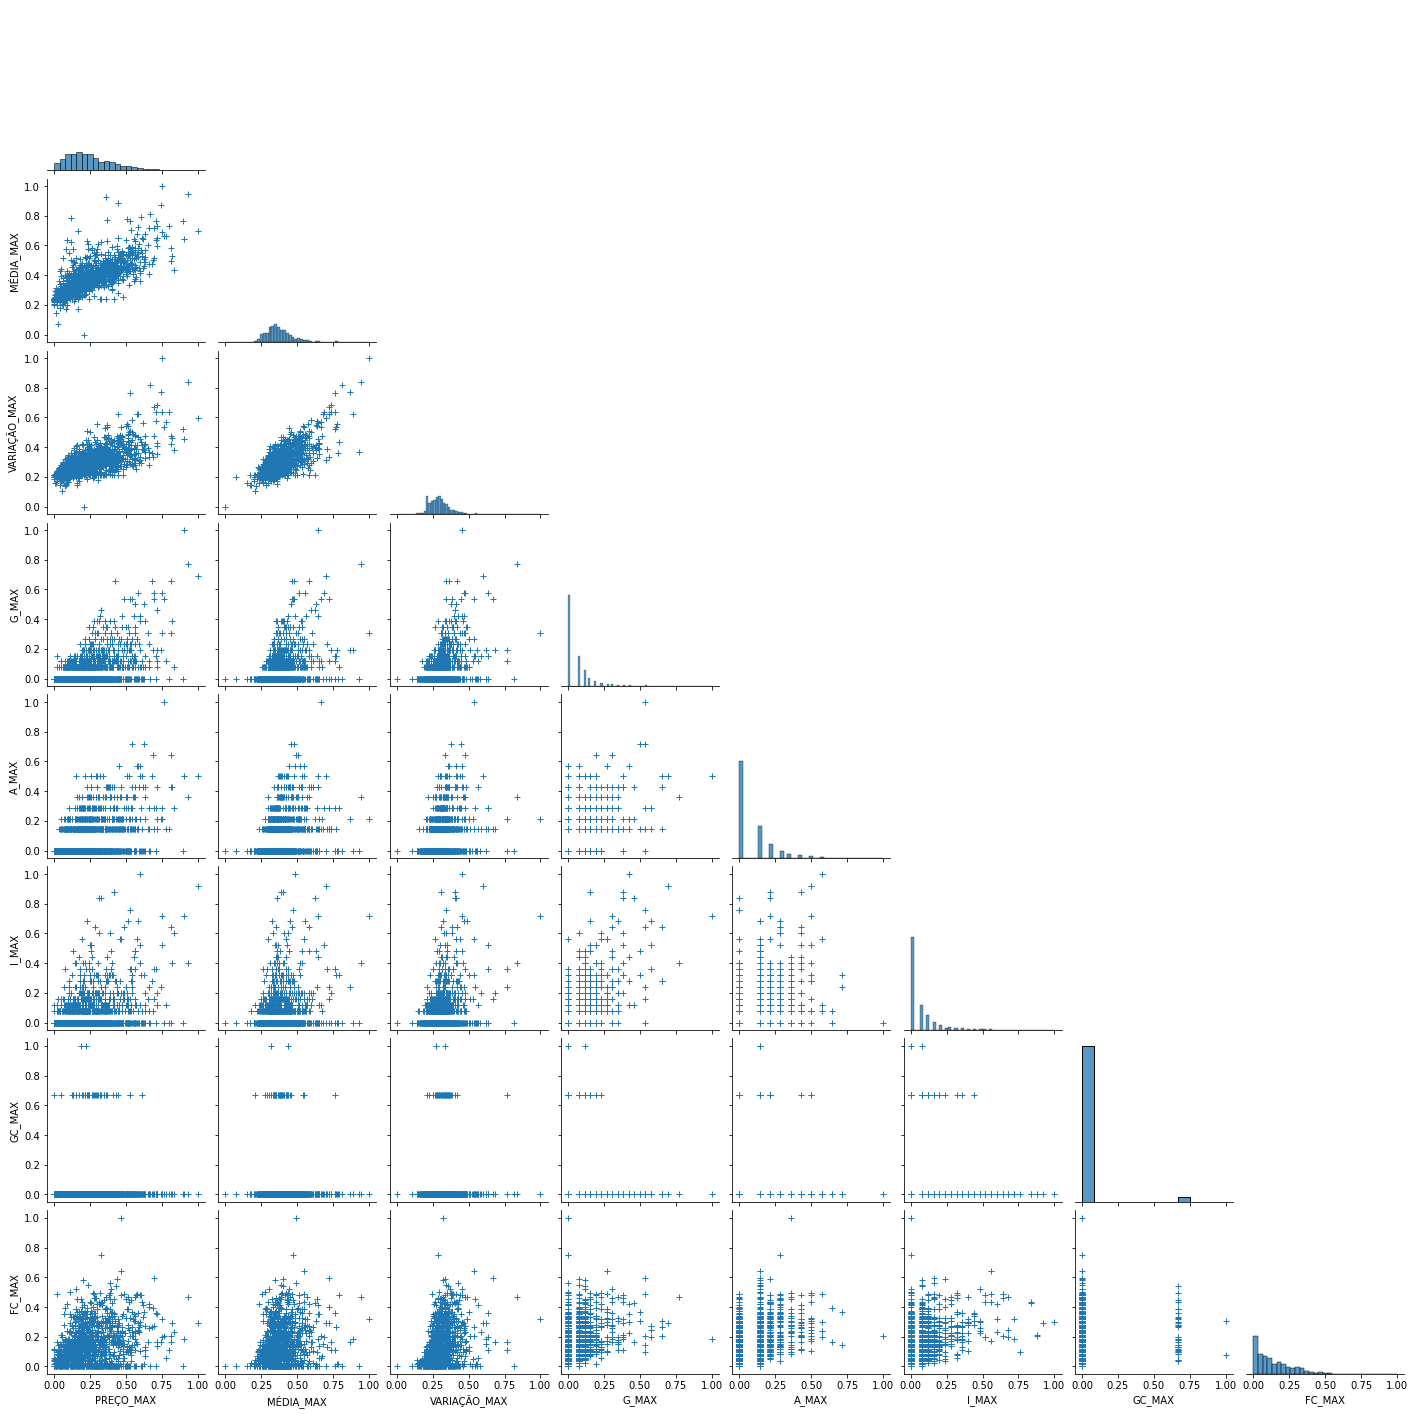

In [75]:
x_ = X.drop(columns=["POS_FIRST"]).copy()
x_[x_.columns] = scaler.fit_transform( x_ )

g = sns.pairplot(x_, corner=True, plot_kws=dict(marker="+", linewidth=1),)

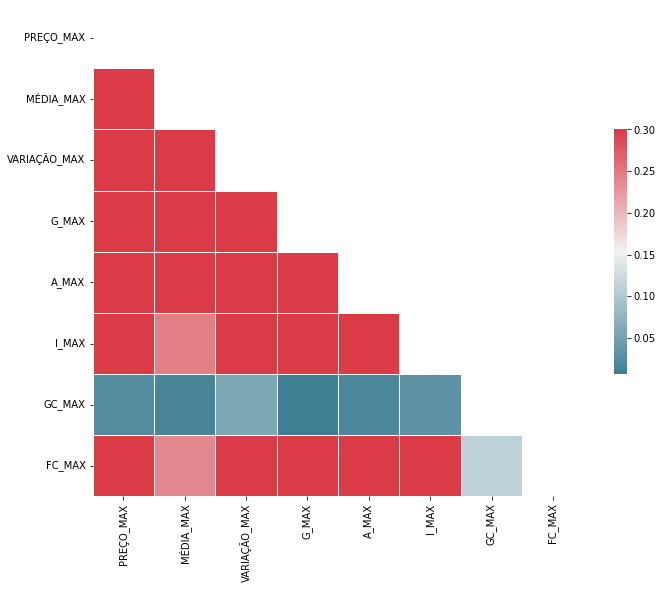

In [76]:
corr = x_.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
);

In [80]:
data = pd.concat([x_, yy], axis=1).copy()
data

PREÇO_MAX  MÉDIA_MAX  VARIAÇÃO_MAX     G_MAX     A_MAX  I_MAX  GC_MAX  \
0      0.414605   0.387960      0.406844  0.384615  0.428571   0.88     0.0   
1      0.194346   0.423411      0.281912  0.153846  0.285714   0.08     0.0   
2      0.151158   0.330769      0.241173  0.115385  0.000000   0.12     0.0   
3      0.340400   0.335117      0.211298  0.000000  0.000000   0.00     0.0   
4      0.175501   0.451505      0.326453  0.076923  0.142857   0.00     0.0   
...         ...        ...           ...       ...       ...    ...     ...   
1278   0.233216   0.419398      0.300923  0.000000  0.000000   0.00     0.0   
1279   0.019631   0.220736      0.211298  0.000000  0.000000   0.08     0.0   
1280   0.088339   0.286288      0.215100  0.115385  0.000000   0.12     0.0   
1281   0.136631   0.321739      0.248778  0.000000  0.000000   0.00     0.0   
1282   0.182960   0.345151      0.326453  0.000000  0.285714   0.12     0.0   

        FC_MAX  POS_FIRST  
0     0.213675      False  
1     0.119658      False  
2     0.230769      False  
3     0.000000      False  
4     0.094017      False  
...        ...        ...  
1278  0.000000      False  
1279  0.000000      False  
1280  0.239316       True  
1281  0.145299      False  
1282  0.333333      False  

[1283 rows x 9 columns]

## modelo

In [81]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(
        "POS_FIRST ~ PREÇO_MAX + MÉDIA_MAX + VARIAÇÃO_MAX + G_MAX + A_MAX + I_MAX + GC_MAX + FC_MAX", data, family=pm.glm.families.Binomial()
    )
    trace = pm.sample(1000, tune=1000, init="adapt_diag")

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [FC_MAX, GC_MAX, I_MAX, A_MAX, G_MAX, VARIAÇÃO_MAX, MÉDIA_MAX, PREÇO_MAX, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


## análise

In [84]:
def plot_traces(traces, model, retain=0):
    """
    Convenience function:
    Plot traces with overlaid means and values
    """
    with model:
        ax = az.plot_trace(
            traces[-retain:],
            lines=tuple([(k, {}, v["mean"]) for k, v in az.summary(traces[-retain:]).iterrows()]),
        )

        for i, mn in enumerate(az.summary(traces[-retain:])["mean"]):
            ax[i, 0].annotate(
                f"{mn:.2f}",
                xy=(mn, 0),
                xycoords="data",
                xytext=(5, 10),
                textcoords="offset points",
                rotation=90,
                va="bottom",
                fontsize="large",
                color="#AA0022",
            )

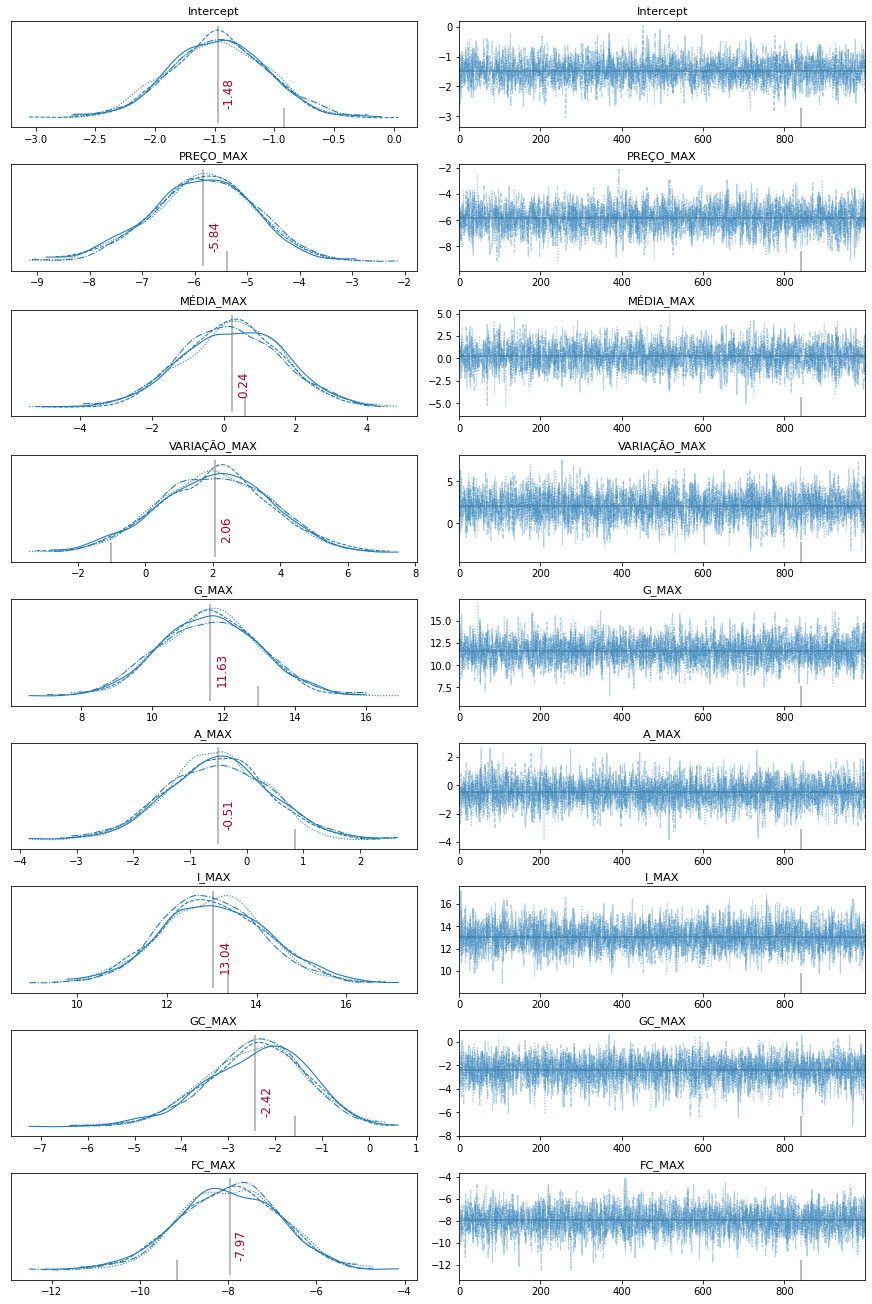

In [85]:
plot_traces(trace, logistic_model);

<Figure size 648x504 with 0 Axes>

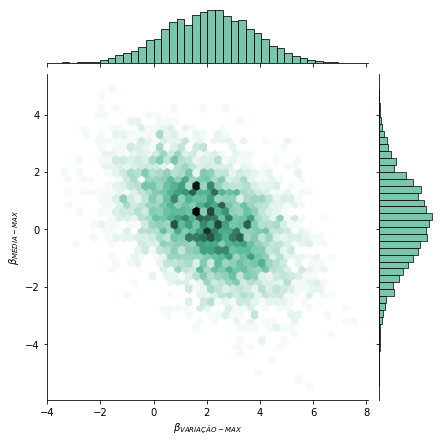

In [96]:
plt.figure(figsize=(9, 7))
sns.jointplot(trace["VARIAÇÃO_MAX"], trace["MÉDIA_MAX"],  kind="hex", color="#4CB391")
plt.xlabel(r"$\beta_{VARIAÇÃO-MAX}$")
plt.ylabel(r"$\beta_{MÉDIA-MAX}$");

# outro classificador binário

In [8]:
df = pd.read_csv('~/Documents/data/cartola-fc-brasil-scouts/jogadores.csv')

df = df.sort_values(by=["ano", "rodada"]).copy()
df['id']  = df['Nome'].apply( lambda x: hashlib.sha1(str.encode(x)).hexdigest() )
df['pos'] = df['Nome'].apply( lambda x: x.split('(')[-1].split(')')[0].strip() )

display( df )

scouts  = ['DS','G','A','SG','FS','FF','FD','FT','DD','DP','GC','CV','CA','PP','GS','FC','I','PI','RB','PE']
mercado = ['Preço', 'Média','Variação']
keys    = ["id", "ano"]

gscouts = df.groupby(keys)[scouts].agg(['max'])
gscouts.columns = gscouts.columns.map('_'.join)
gscouts = gscouts.reset_index()

gmercado = df.groupby(keys)[mercado].agg(['max'])
gmercado.columns = gmercado.columns.map('_'.join)
gmercado = gmercado.reset_index()

gpos = df.groupby(keys)[['pos']].agg(['first'])
gpos.columns = gpos.columns.map('_'.join)
gpos = gpos.reset_index()

display(gpos['pos_first'].value_counts())

Nome         Clube  Preço    J  Média  Últ. Pont.  \
7882     Ricardo Bueno (ATA)         Ceará  18.52  1.0  22.70        22.7   
7883    Bruno Henrique (ATA)      Flamengo  21.51  1.0  21.00        21.0   
7884             Nikão (MEI)  Athlético-PR  19.29  1.0  18.80        18.8   
7885             Tiepo (GOL)   Chapecoense  13.18  1.0  17.00        17.0   
7886         Vanderlei (GOL)        Santos  22.69  1.0  15.70        15.7   
...                      ...           ...    ...  ...    ...         ...   
7877            Jadson (MEI)  Athlético-PR   3.53  9.0   0.11         0.8   
7878  Patrick de Lucca (MEI)         Bahia   0.77  3.0  -0.23        -1.5   
7879    Guilherme Biro (ATA)      Coritiba   0.77  8.0  -0.32        -3.6   
7880   Gabriel Pereira (MEI)   Corinthians   0.79  5.0  -0.40         0.0   
7881        Wellington (LAT)     São Paulo   0.77  1.0  -3.10        -3.1   

      Variação    DS    G    A  ...   GS    FC    I    PI  rodada   ano   RB  \
7882     14.52   NaN  2.0  1.0  ...  NaN   2.0  1.0   NaN       1  2019  1.0   
7883     11.51   NaN  2.0  NaN  ...  NaN   1.0  NaN   NaN       1  2019  NaN   
7884     10.29   NaN  1.0  NaN  ...  NaN   1.0  NaN   NaN       1  2019  5.0   
7885     11.18   NaN  NaN  NaN  ...  NaN   NaN  NaN   NaN       1  2019  NaN   
7886      5.69   NaN  NaN  NaN  ...  1.0   NaN  NaN   NaN       1  2019  NaN   
...        ...   ...  ...  ...  ...  ...   ...  ...   ...     ...   ...  ...   
7877     -0.40   NaN  NaN  NaN  ...  NaN   3.0  NaN  40.0      38  2020  NaN   
7878     -0.29   1.0  NaN  NaN  ...  NaN   NaN  NaN  25.0      38  2020  NaN   
7879     -0.21  15.0  NaN  NaN  ...  NaN  14.0  NaN  41.0      38  2020  NaN   
7880      0.00   1.0  NaN  NaN  ...  NaN   6.0  NaN  15.0      38  2020  NaN   
7881     -0.23   NaN  NaN  NaN  ...  NaN   4.0  NaN   1.0      38  2020  NaN   

       PE                                        id  pos  
7882  1.0  1f4d452190fb0558c5f5696b944b9afe4b02ca08  ATA  
7883  NaN  9f9a076464350d81d76c9b8940d64b9890e4b053  ATA  
7884  NaN  9752a812f300239c0f4fcae95d41e2843653a308  MEI  
7885  NaN  ec9799d86e28ec368cccfb660bf39ff3bc3eed7c  GOL  
7886  1.0  a5dde5accc0044a9808b0257f6faa5ba89342b7f  GOL  
...   ...                                       ...  ...  
7877  NaN  fe95e28e44efa7db07376c045a2fa89332ea5308  MEI  
7878  NaN  0157594398527348fc28f663c44291f22f8172ae  MEI  
7879  NaN  3e299fb9c705d57573fa4ab8a1a9f607edc60dc2  ATA  
7880  NaN  90a8b33c4ac288f85fa4a7e678592dd30600d8a4  MEI  
7881  NaN  e56896e9bd7426de5236ee5280c369328818c6c3  LAT  

[16404 rows x 31 columns]

MEI    408
ATA    285
ZAG    203
LAT    200
GOL     96
TEC     91
Name: pos_first, dtype: int64

In [9]:
cols_ = ["Preço_max", "Média_max", "Variação_max", "G_max", "A_max", "I_max", "GC_max", "FC_max", "pos_first"]
X = pd.concat([gscouts.drop(columns=keys), gmercado.drop(columns=keys), gpos.drop(columns=keys)], axis=1).copy().fillna(-1.0)[cols_]
X.columns = X.columns.str.upper()

In [10]:
scaler = StandardScaler()
scaler = MinMaxScaler()

yy = pd.Categorical(1 * X["POS_FIRST"] == "ATA").codes
# yy = pd.Categorical(X["POS_FIRST"])
xx = scaler.fit_transform( X.drop(columns=["POS_FIRST"]) )

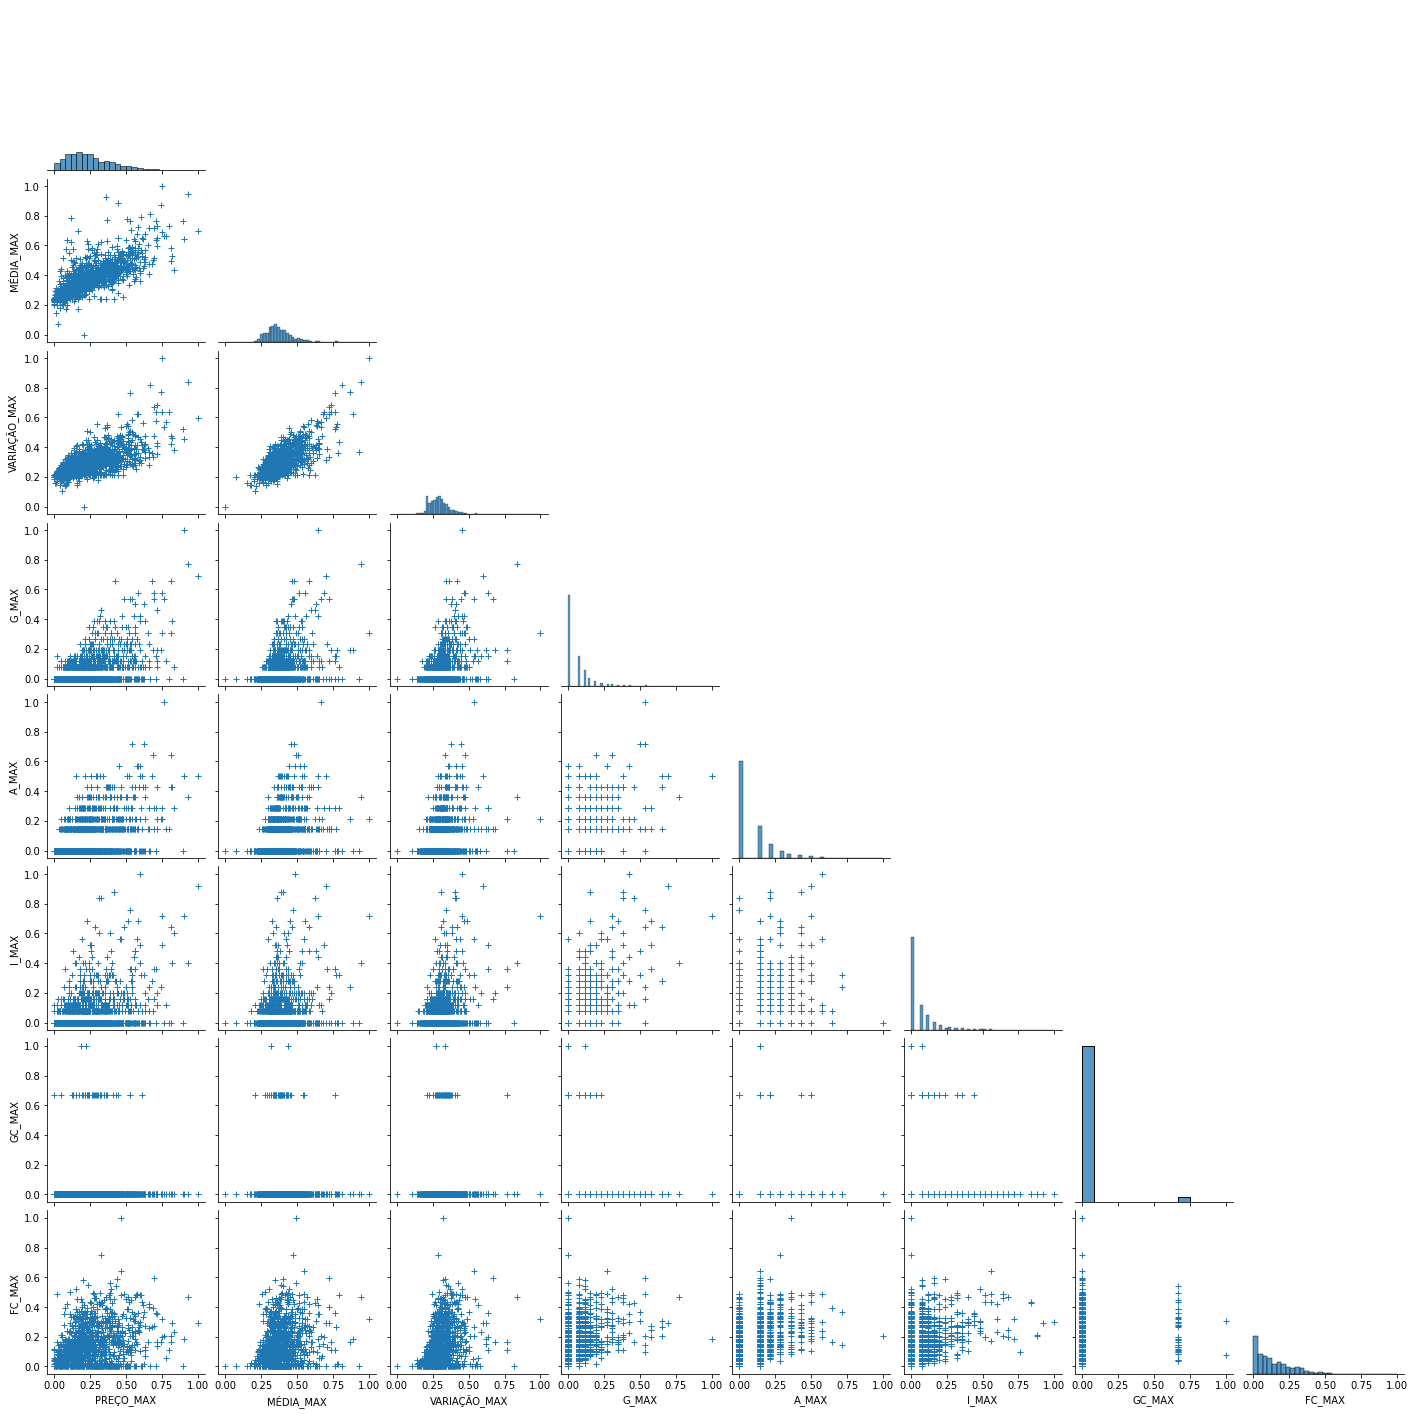

In [11]:
x_ = X.drop(columns=["POS_FIRST"]).copy()
x_[x_.columns] = scaler.fit_transform( x_ )

g = sns.pairplot(x_, corner=True, plot_kws=dict(marker="+", linewidth=1),)

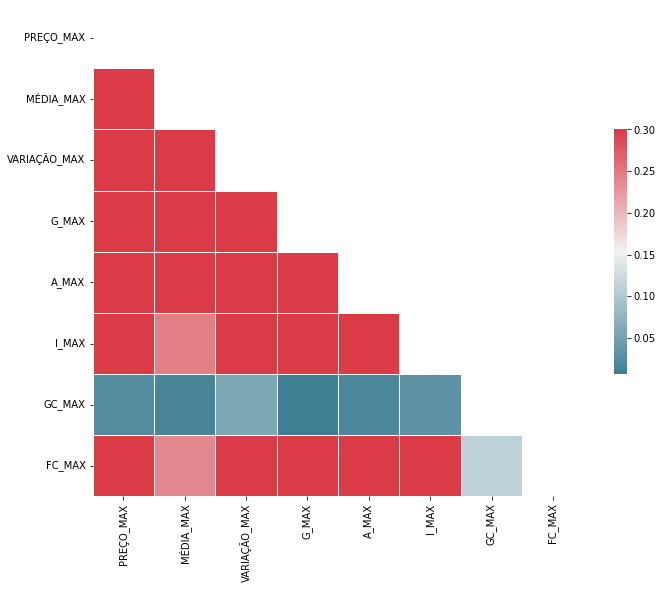

In [12]:
corr = x_.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
);

In [13]:
gc.collect()

247

## seleção

In [14]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=5, n_estimators=500, oob_score=True)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, max_iter=23)

feat_selector.fit(x_.values, yy)

Iteration: 	1 / 23
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	2 / 23
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	3 / 23
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	4 / 23
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	5 / 23
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	6 / 23
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	7 / 23
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	8 / 23
Confirmed: 	5
Tentative: 	1
Rejected: 	2
Iteration: 	9 / 23
Confirmed: 	5
Tentative: 	1
Rejected: 	2
Iteration: 	10 / 23
Confirmed: 	5
Tentative: 	1
Rejected: 	2
Iteration: 	11 / 23
Confirmed: 	5
Tentative: 	1
Rejected: 	2
Iteration: 	12 / 23
Confirmed: 	6
Tentative: 	0
Rejected: 	2


BorutaPy finished running.

Iteration: 	13 / 23
Confirmed: 	6
Tentative: 	0
Rejected: 	2


BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=69,
                                          n_jobs=-1, oob_score=True,
                                          random_state=RandomState(MT19937) at 0x7F3E906E4140),
         max_iter=23, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F3E906E4140, verbose=2)

In [15]:
accept = x_.columns[feat_selector.support_].to_list()
irresolution = x_.columns[feat_selector.support_weak_].to_list()

In [16]:
xx_ = feat_selector.transform(x_.values)

print('Accepted features:')
print('----------------------------')
print(list(accept))
print('----------------------------')
print(list(irresolution))

Accepted features:
----------------------------
['PREÇO_MAX', 'MÉDIA_MAX', 'VARIAÇÃO_MAX', 'G_MAX', 'I_MAX', 'FC_MAX']
----------------------------
[]


In [17]:
gc.collect()

120

## modelo

+ $ \theta = \sigma( \alpha + x\beta)$
+ $ y \sim Bern(\theta) $

In [18]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

for train_index, test_index in skf.split(x_[accept], yy):
    Xt, Xh = x_.iloc[train_index][accept], x_.iloc[test_index][accept]
    yt, yh = yy[train_index], yy[test_index]
    
    print(Xt.shape, Xh.shape, yt.shape, yh.shape)

(855, 6) (428, 6) (855,) (428,)
(855, 6) (428, 6) (855,) (428,)
(856, 6) (427, 6) (856,) (427,)


In [18]:
with pm.Model() as model_reglog:
    data = pm.Data("data", Xt.values)
    
    alfa = pm.Normal("alfa", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=2, shape=len(Xt) )

    mu = alfa + pm.math.dot(data, beta)
    teta = pm.Deterministic("teta", pm.math.sigmoid(mu))

    yl = pm.Bernoulli("yl", p=teta, observed=yt)

    trace = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alfa]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 173 seconds.
The acceptance probability does not match the target. It is 0.8972060049149853, but should be close to 0.8. Try to increase the number of tuning steps.


In [19]:
gc.collect()

57596

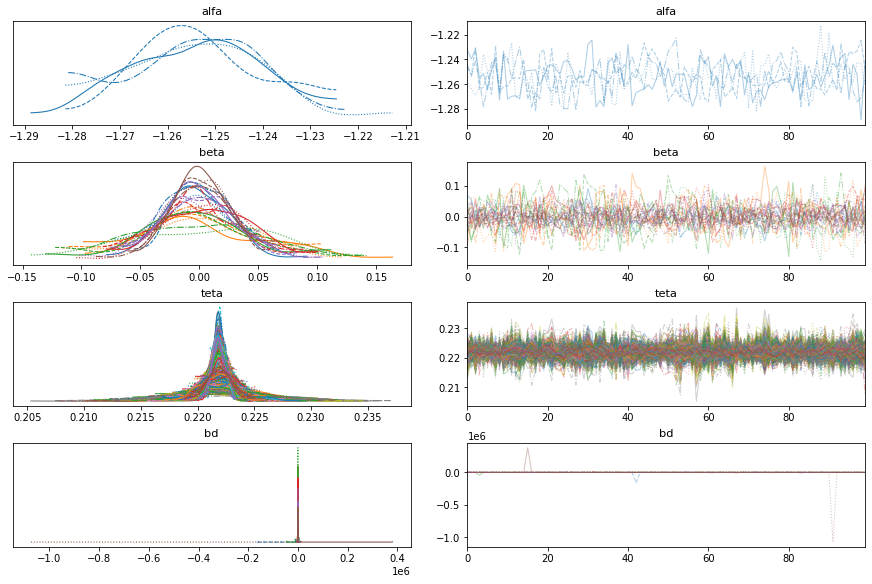

In [20]:
az.plot_trace(data=trace);

In [21]:
az.summary(trace).T.filter(like="beta").T

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0,0] -0.001  0.029  -0.051    0.053      0.002    0.001     299.0   
beta[1,0] -0.000  0.049  -0.096    0.091      0.003    0.003     315.0   
beta[2,0] -0.001  0.053  -0.106    0.096      0.003    0.003     323.0   
beta[3,0]  0.003  0.037  -0.067    0.071      0.002    0.002     251.0   
beta[4,0] -0.001  0.032  -0.056    0.057      0.002    0.001     336.0   
beta[5,0]  0.001  0.024  -0.040    0.047      0.001    0.001     423.0   

           ess_tail  r_hat  
beta[0,0]     227.0   1.01  
beta[1,0]     232.0   1.01  
beta[2,0]     239.0   1.02  
beta[3,0]     304.0   1.00  
beta[4,0]     295.0   1.01  
beta[5,0]     308.0   1.00

In [65]:
summary_ = az.summary(trace).copy()
params_ = summary_["mean"].filter(regex="alfa|beta") 
params_

alfa        -1.254
beta[0,0]   -0.001
beta[1,0]   -0.000
beta[2,0]   -0.001
beta[3,0]    0.003
beta[4,0]   -0.001
beta[5,0]    0.001
Name: mean, dtype: float64

In [72]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [89]:
cols = Xt.columns.tolist()
t_prob = Xt.copy()
t_prob["1"] = 1.0

t_prob["dot"] = (params_.values * t_prob[["1"] + cols]).sum(axis=1)
t_prob["prob"] = t_prob["dot"].apply( sigmoid )
t_prob["pred"] = (t_prob["prob"] >= 0.5).astype("int")

<AxesSubplot:>

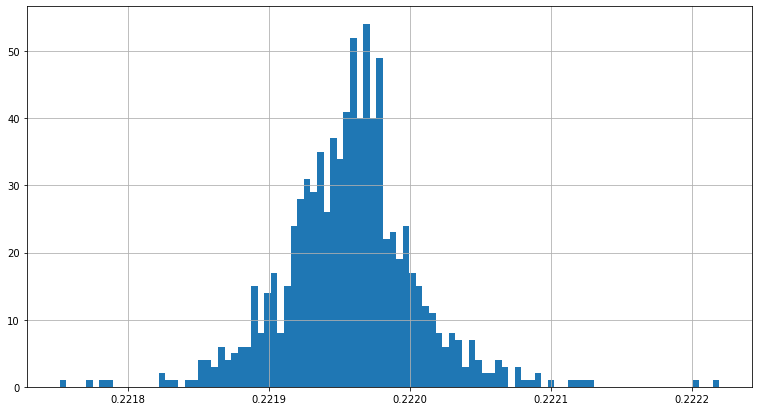

In [90]:
t_prob["prob"].hist(bins=100)

In [19]:
gc.collect()

0

# mais um classificador binário

In [88]:
df = pd.read_csv('~/Documents/data/cartola-fc-brasil-scouts/jogadores.csv')

df = df.sort_values(by=["ano", "rodada"]).copy()
df['id']  = df['Nome'].apply( lambda x: hashlib.sha1(str.encode(x)).hexdigest() )
df['pos'] = df['Nome'].apply( lambda x: x.split('(')[-1].split(')')[0].strip() )

display( df )

scouts  = ['DS','G','A','SG','FS','FF','FD','FT','DD','DP','GC','CV','CA','PP','GS','FC','I','PI','RB','PE']
mercado = ['Preço', 'Média','Variação']
keys    = ["id", "ano"]

gscouts = df.groupby(keys)[scouts].agg(['max'])
gscouts.columns = gscouts.columns.map('_'.join)
gscouts = gscouts.reset_index()

gmercado = df.groupby(keys)[mercado].agg(['max'])
gmercado.columns = gmercado.columns.map('_'.join)
gmercado = gmercado.reset_index()

gpos = df.groupby(keys)[['pos']].agg(['first'])
gpos.columns = gpos.columns.map('_'.join)
gpos = gpos.reset_index()

display(gpos['pos_first'].value_counts())

Nome         Clube  Preço    J  Média  Últ. Pont.  \
7882     Ricardo Bueno (ATA)         Ceará  18.52  1.0  22.70        22.7   
7883    Bruno Henrique (ATA)      Flamengo  21.51  1.0  21.00        21.0   
7884             Nikão (MEI)  Athlético-PR  19.29  1.0  18.80        18.8   
7885             Tiepo (GOL)   Chapecoense  13.18  1.0  17.00        17.0   
7886         Vanderlei (GOL)        Santos  22.69  1.0  15.70        15.7   
...                      ...           ...    ...  ...    ...         ...   
7877            Jadson (MEI)  Athlético-PR   3.53  9.0   0.11         0.8   
7878  Patrick de Lucca (MEI)         Bahia   0.77  3.0  -0.23        -1.5   
7879    Guilherme Biro (ATA)      Coritiba   0.77  8.0  -0.32        -3.6   
7880   Gabriel Pereira (MEI)   Corinthians   0.79  5.0  -0.40         0.0   
7881        Wellington (LAT)     São Paulo   0.77  1.0  -3.10        -3.1   

      Variação    DS    G    A  ...   GS    FC    I    PI  rodada   ano   RB  \
7882     14.52   NaN  2.0  1.0  ...  NaN   2.0  1.0   NaN       1  2019  1.0   
7883     11.51   NaN  2.0  NaN  ...  NaN   1.0  NaN   NaN       1  2019  NaN   
7884     10.29   NaN  1.0  NaN  ...  NaN   1.0  NaN   NaN       1  2019  5.0   
7885     11.18   NaN  NaN  NaN  ...  NaN   NaN  NaN   NaN       1  2019  NaN   
7886      5.69   NaN  NaN  NaN  ...  1.0   NaN  NaN   NaN       1  2019  NaN   
...        ...   ...  ...  ...  ...  ...   ...  ...   ...     ...   ...  ...   
7877     -0.40   NaN  NaN  NaN  ...  NaN   3.0  NaN  40.0      38  2020  NaN   
7878     -0.29   1.0  NaN  NaN  ...  NaN   NaN  NaN  25.0      38  2020  NaN   
7879     -0.21  15.0  NaN  NaN  ...  NaN  14.0  NaN  41.0      38  2020  NaN   
7880      0.00   1.0  NaN  NaN  ...  NaN   6.0  NaN  15.0      38  2020  NaN   
7881     -0.23   NaN  NaN  NaN  ...  NaN   4.0  NaN   1.0      38  2020  NaN   

       PE                                        id  pos  
7882  1.0  1f4d452190fb0558c5f5696b944b9afe4b02ca08  ATA  
7883  NaN  9f9a076464350d81d76c9b8940d64b9890e4b053  ATA  
7884  NaN  9752a812f300239c0f4fcae95d41e2843653a308  MEI  
7885  NaN  ec9799d86e28ec368cccfb660bf39ff3bc3eed7c  GOL  
7886  1.0  a5dde5accc0044a9808b0257f6faa5ba89342b7f  GOL  
...   ...                                       ...  ...  
7877  NaN  fe95e28e44efa7db07376c045a2fa89332ea5308  MEI  
7878  NaN  0157594398527348fc28f663c44291f22f8172ae  MEI  
7879  NaN  3e299fb9c705d57573fa4ab8a1a9f607edc60dc2  ATA  
7880  NaN  90a8b33c4ac288f85fa4a7e678592dd30600d8a4  MEI  
7881  NaN  e56896e9bd7426de5236ee5280c369328818c6c3  LAT  

[16404 rows x 31 columns]

MEI    408
ATA    285
ZAG    203
LAT    200
GOL     96
TEC     91
Name: pos_first, dtype: int64

In [90]:
cols_ = ["Preço_max", "Média_max", "Variação_max", "G_max", "A_max", "I_max", "GC_max", "FC_max", "pos_first"]
X = pd.concat([gscouts.drop(columns=keys), gmercado.drop(columns=keys), gpos.drop(columns=keys)], axis=1).copy().fillna(-1.0)#[cols_]
X.columns = X.columns.str.upper()

In [91]:
scaler = StandardScaler()
scaler = MinMaxScaler()

yy = pd.Categorical(1 * X["POS_FIRST"] == "ATA").codes
# yy = pd.Categorical(X["POS_FIRST"])
xx = scaler.fit_transform( X.drop(columns=["POS_FIRST"]) )

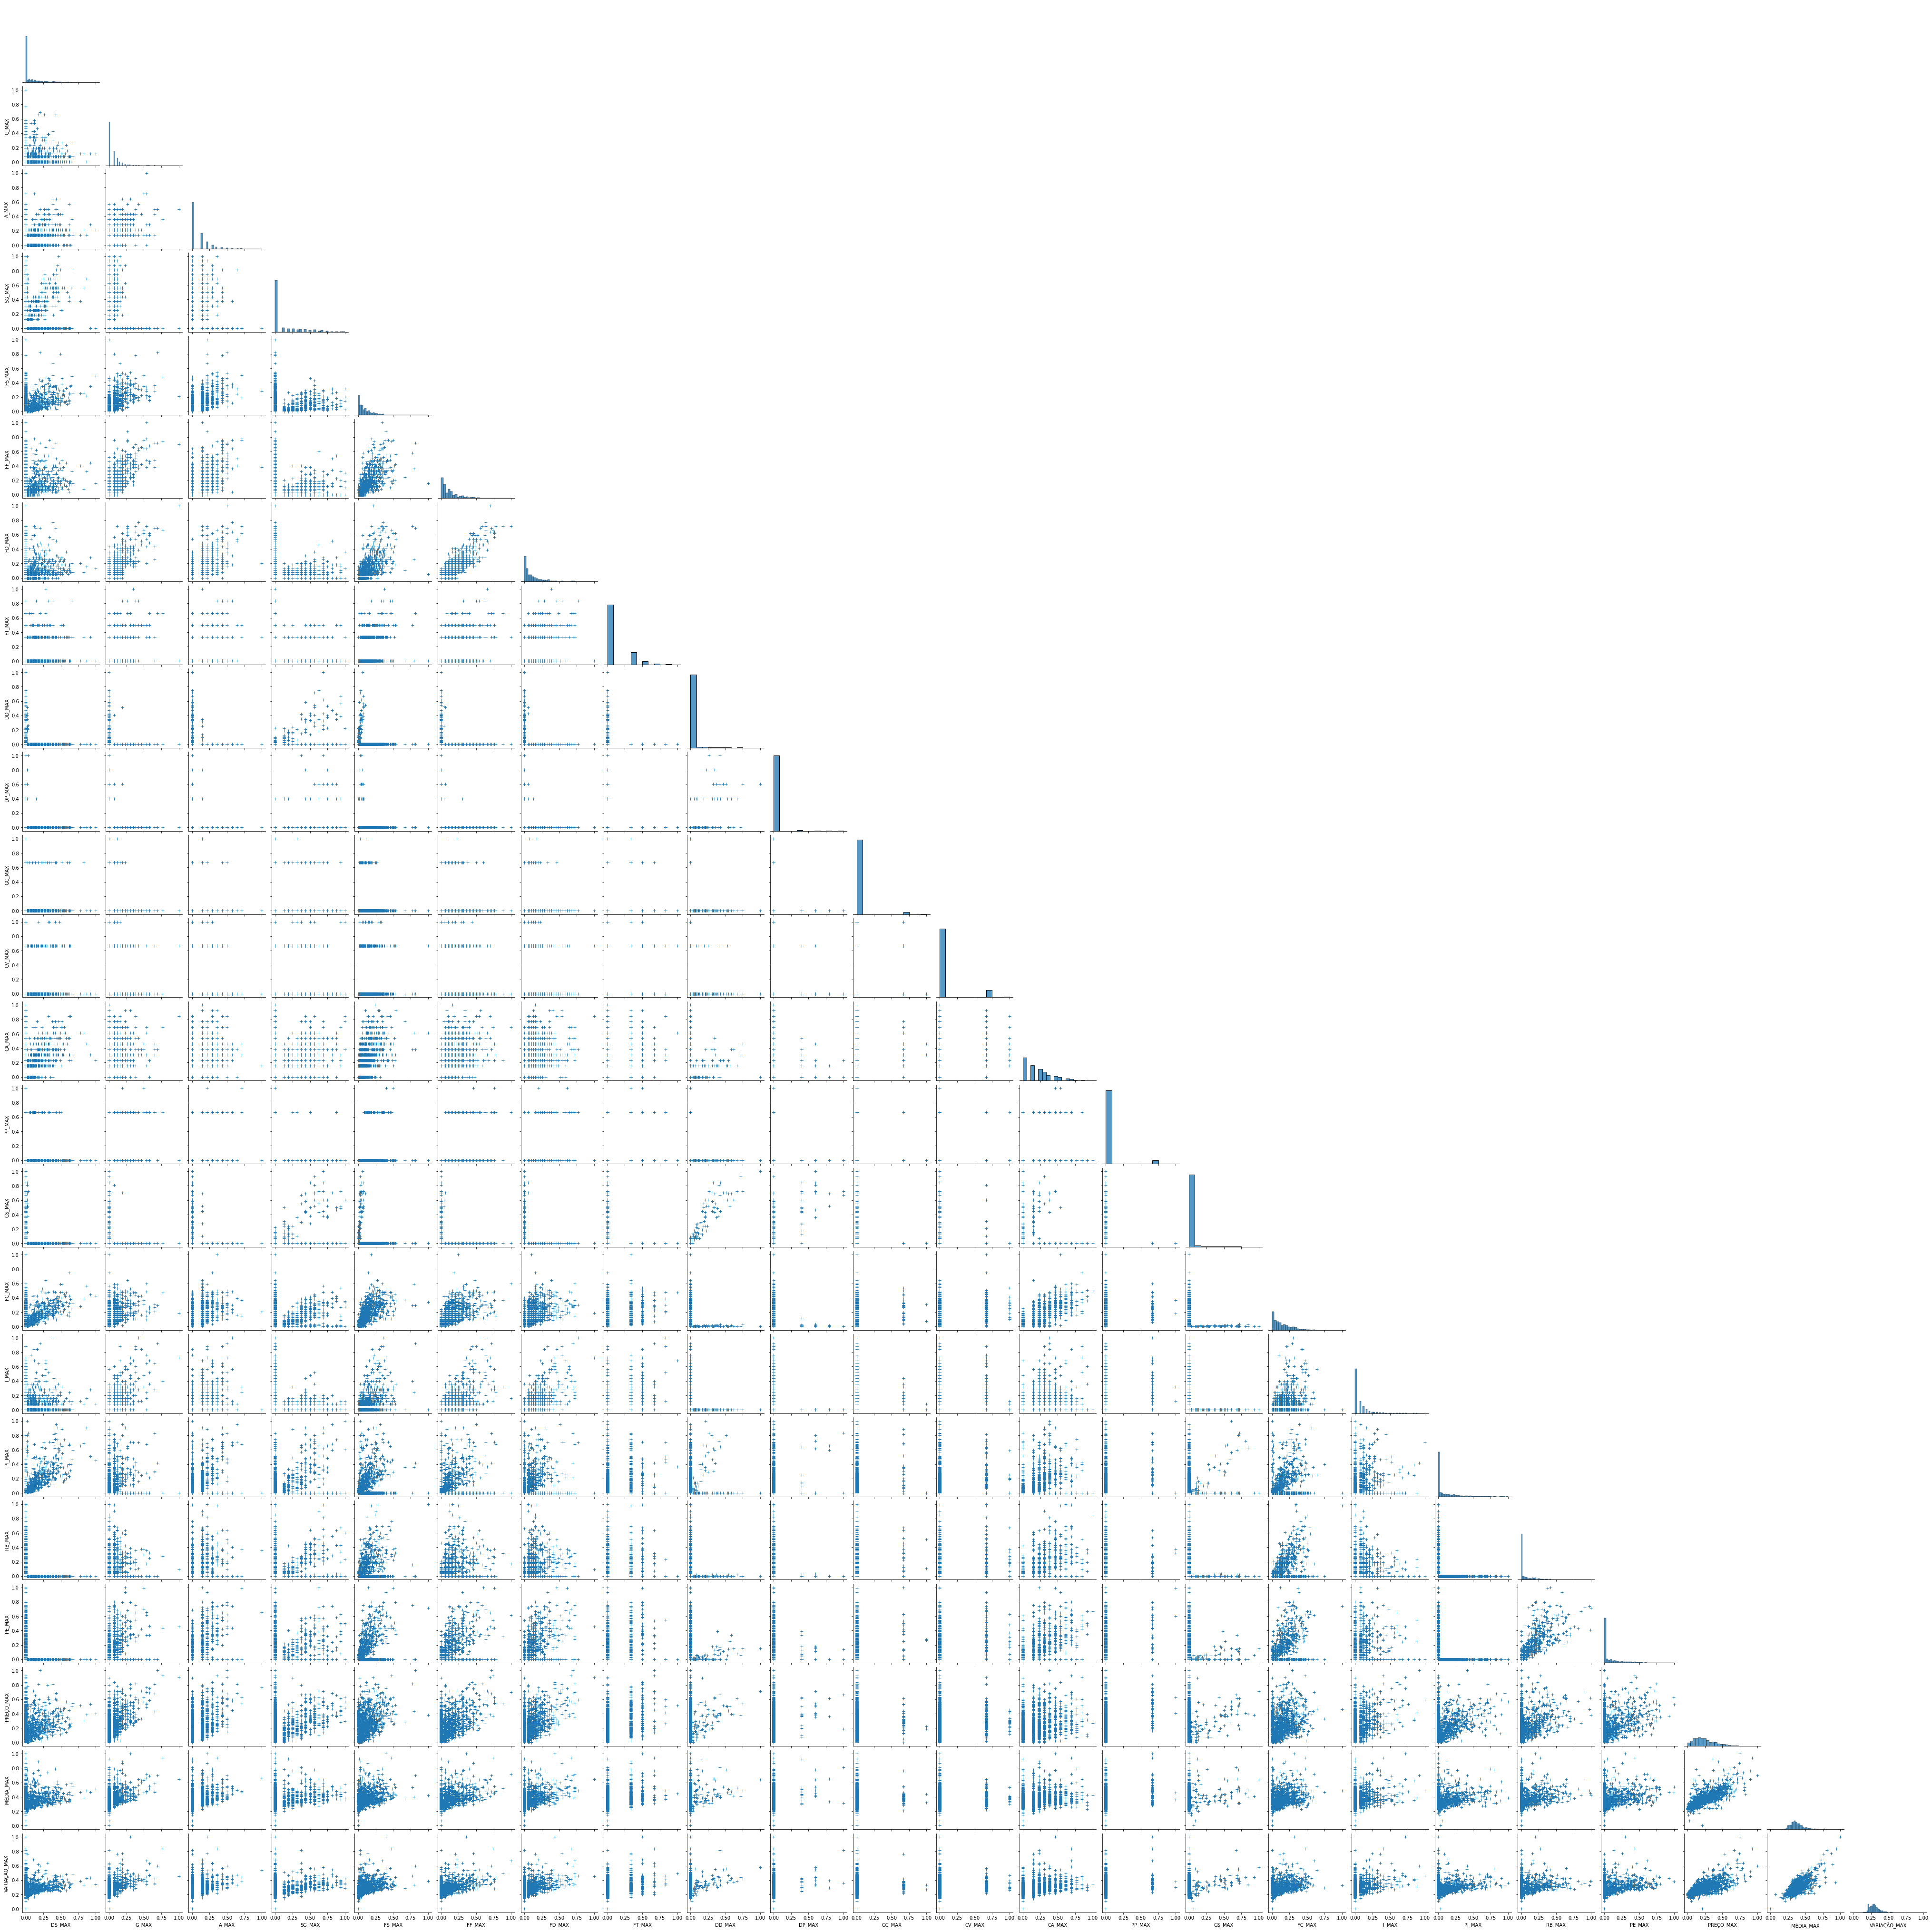

In [92]:
x_ = X.drop(columns=["POS_FIRST"]).copy()
x_[x_.columns] = scaler.fit_transform( x_ )

g = sns.pairplot(x_, corner=True, plot_kws=dict(marker="+", linewidth=1),)

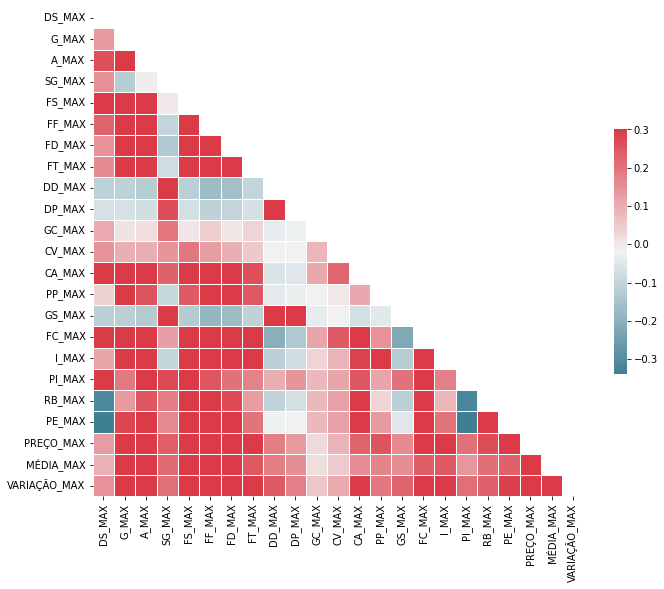

In [93]:
corr = x_.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
);

In [94]:
gc.collect()

157620

## seleção

In [96]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=10, n_estimators=500, oob_score=True)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, max_iter=23)

feat_selector.fit(x_.values, yy)

Iteration: 	1 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 23
Confirmed: 	11
Tentative: 	4
Rejected: 	8
Iteration: 	9 / 23
Confirmed: 	11
Tentative: 	4
Rejected: 	8
Iteration: 	10 / 23
Confirmed: 	11
Tentative: 	4
Rejected: 	8
Iteration: 	11 / 23
Confirmed: 	11
Tentative: 	4
Rejected: 	8
Iteration: 	12 / 23
Confirmed: 	11
Tentative: 	3
Rejected: 	9
Iteration: 	13 / 23
Confirmed: 	11
Tentative: 	3
Rejected: 	9
Iteration: 	14 / 23
Confirmed: 	11
Tentative: 	3
Rejected: 	9
Iteration: 	15 / 23
Confirmed: 	11
Tentative: 	3
Rejected: 	9
Iteration: 	16 / 23
Confirmed: 	12
Tentative: 	2
Rejected: 	9
Iteration: 	17 / 

BorutaPy(estimator=RandomForestClassifier(max_depth=10, n_estimators=52,
                                          n_jobs=-1, oob_score=True,
                                          random_state=RandomState(MT19937) at 0x7F3E51AA0040),
         max_iter=23, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F3E51AA0040, verbose=2)

In [97]:
accept = x_.columns[feat_selector.support_].to_list()
irresolution = x_.columns[feat_selector.support_weak_].to_list()

In [98]:
xx_ = feat_selector.transform(x_.values)

print('Accepted features:')
print('----------------------------')
print(list(accept))
print('----------------------------')
print(list(irresolution))

Accepted features:
----------------------------
['DS_MAX', 'G_MAX', 'SG_MAX', 'FS_MAX', 'FF_MAX', 'FD_MAX', 'CA_MAX', 'FC_MAX', 'I_MAX', 'RB_MAX', 'PREÇO_MAX', 'VARIAÇÃO_MAX']
----------------------------
['PI_MAX', 'MÉDIA_MAX']


In [99]:
gc.collect()

264

## modelo

+ $ \theta = \sigma( \alpha + x\beta) $
+ $ y \sim Bern(\theta) $

$$ p = logit\left( \beta_0 + \sum_{c}\beta_{c}X_c\right)$$

In [100]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

for train_index, test_index in skf.split(x_[accept], yy):
    Xt, Xh = x_.iloc[train_index][accept], x_.iloc[test_index][accept]
    yt, yh = yy[train_index], yy[test_index]
    
    print(Xt.shape, Xh.shape, yt.shape, yh.shape)

(855, 12) (428, 12) (855,) (428,)
(855, 12) (428, 12) (855,) (428,)
(856, 12) (427, 12) (856,) (427,)


In [101]:
lower  = -10**6
higher = 10**6

In [102]:
for c in Xt.columns:
    print(rf"""beta_{c} = pm.Uniform("beta_{c}", lower=lower, upper=higher)""".replace("Ç", "C").replace("É", "E").replace("Ã", "A"))

beta_DS_MAX = pm.Uniform("beta_DS_MAX", lower=lower, upper=higher)
beta_G_MAX = pm.Uniform("beta_G_MAX", lower=lower, upper=higher)
beta_SG_MAX = pm.Uniform("beta_SG_MAX", lower=lower, upper=higher)
beta_FS_MAX = pm.Uniform("beta_FS_MAX", lower=lower, upper=higher)
beta_FF_MAX = pm.Uniform("beta_FF_MAX", lower=lower, upper=higher)
beta_FD_MAX = pm.Uniform("beta_FD_MAX", lower=lower, upper=higher)
beta_CA_MAX = pm.Uniform("beta_CA_MAX", lower=lower, upper=higher)
beta_FC_MAX = pm.Uniform("beta_FC_MAX", lower=lower, upper=higher)
beta_I_MAX = pm.Uniform("beta_I_MAX", lower=lower, upper=higher)
beta_RB_MAX = pm.Uniform("beta_RB_MAX", lower=lower, upper=higher)
beta_PRECO_MAX = pm.Uniform("beta_PRECO_MAX", lower=lower, upper=higher)
beta_VARIACAO_MAX = pm.Uniform("beta_VARIACAO_MAX", lower=lower, upper=higher)


In [103]:
for c in Xt.columns:
    print(rf"""beta_{c.replace("Ç", "C").replace("É", "E").replace("Ã", "A")} * Xt["{c}"] +""")

beta_DS_MAX * Xt["DS_MAX"] +
beta_G_MAX * Xt["G_MAX"] +
beta_SG_MAX * Xt["SG_MAX"] +
beta_FS_MAX * Xt["FS_MAX"] +
beta_FF_MAX * Xt["FF_MAX"] +
beta_FD_MAX * Xt["FD_MAX"] +
beta_CA_MAX * Xt["CA_MAX"] +
beta_FC_MAX * Xt["FC_MAX"] +
beta_I_MAX * Xt["I_MAX"] +
beta_RB_MAX * Xt["RB_MAX"] +
beta_PRECO_MAX * Xt["PREÇO_MAX"] +
beta_VARIACAO_MAX * Xt["VARIAÇÃO_MAX"] +


In [61]:
try:
    del model_reglog
except:
    pass

In [104]:
with pm.Model() as model_reglog:    
    beta_0 = pm.Uniform("beta_0", lower=lower, upper=higher)
    beta_DS_MAX = pm.Uniform("beta_DS_MAX", lower=lower, upper=higher)
    beta_G_MAX = pm.Uniform("beta_G_MAX", lower=lower, upper=higher)
    beta_SG_MAX = pm.Uniform("beta_SG_MAX", lower=lower, upper=higher)
    beta_FS_MAX = pm.Uniform("beta_FS_MAX", lower=lower, upper=higher)
    beta_FF_MAX = pm.Uniform("beta_FF_MAX", lower=lower, upper=higher)
    beta_FD_MAX = pm.Uniform("beta_FD_MAX", lower=lower, upper=higher)
    beta_CA_MAX = pm.Uniform("beta_CA_MAX", lower=lower, upper=higher)
    beta_FC_MAX = pm.Uniform("beta_FC_MAX", lower=lower, upper=higher)
    beta_I_MAX = pm.Uniform("beta_I_MAX", lower=lower, upper=higher)
    beta_RB_MAX = pm.Uniform("beta_RB_MAX", lower=lower, upper=higher)
    beta_PRECO_MAX = pm.Uniform("beta_PRECO_MAX", lower=lower, upper=higher)
    beta_VARIACAO_MAX = pm.Uniform("beta_VARIACAO_MAX", lower=lower, upper=higher)
    
    p = pm.Deterministic(
        "p",
        pm.math.sigmoid(
            beta_0 + 
            beta_DS_MAX * Xt["DS_MAX"] +
            beta_G_MAX * Xt["G_MAX"] +
            beta_SG_MAX * Xt["SG_MAX"] +
            beta_FS_MAX * Xt["FS_MAX"] +
            beta_FF_MAX * Xt["FF_MAX"] +
            beta_FD_MAX * Xt["FD_MAX"] +
            beta_CA_MAX * Xt["CA_MAX"] +
            beta_FC_MAX * Xt["FC_MAX"] +
            beta_I_MAX * Xt["I_MAX"] +
            beta_RB_MAX * Xt["RB_MAX"] +
            beta_PRECO_MAX * Xt["PREÇO_MAX"] +
            beta_VARIACAO_MAX * Xt["VARIAÇÃO_MAX"]
        )
    )

In [105]:
with model_reglog:
    observed = pm.Bernoulli("target", p, observed=yt)
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    n_ = 20000
    trace = pm.sample(n_, step=step, start=start)
    SG = trace[int(0.75 * n_):]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_VARIACAO_MAX]
>Metropolis: [beta_PRECO_MAX]
>Metropolis: [beta_RB_MAX]
>Metropolis: [beta_I_MAX]
>Metropolis: [beta_FC_MAX]
>Metropolis: [beta_CA_MAX]
>Metropolis: [beta_FD_MAX]
>Metropolis: [beta_FF_MAX]
>Metropolis: [beta_FS_MAX]
>Metropolis: [beta_SG_MAX]
>Metropolis: [beta_G_MAX]
>Metropolis: [beta_DS_MAX]
>Metropolis: [beta_0]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 52 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


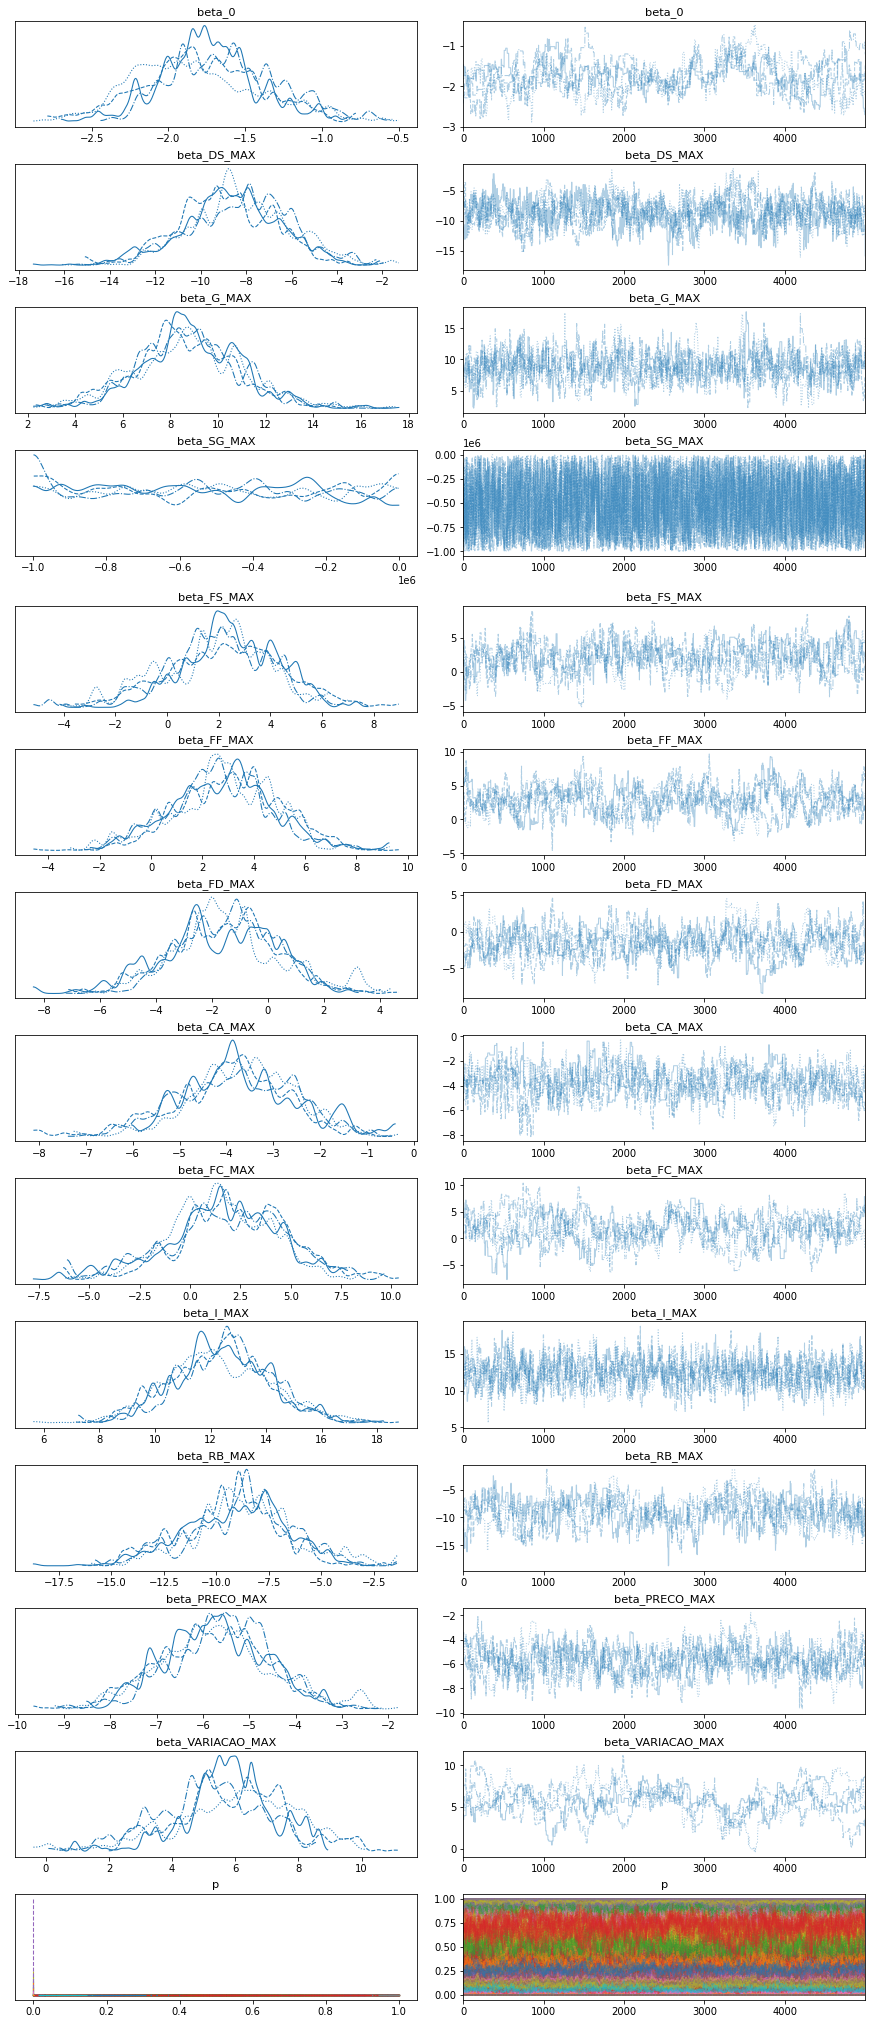

In [106]:
pm.traceplot(burned_trace) 
plt.show()

In [107]:
gc.collect()

924112

In [108]:
for c in Xt.columns:
    print(rf""" 'beta_{c.replace("Ç", "C").replace("É", "E").replace("Ã", "A")}' """)

 'beta_DS_MAX' 
 'beta_G_MAX' 
 'beta_SG_MAX' 
 'beta_FS_MAX' 
 'beta_FF_MAX' 
 'beta_FD_MAX' 
 'beta_CA_MAX' 
 'beta_FC_MAX' 
 'beta_I_MAX' 
 'beta_RB_MAX' 
 'beta_PRECO_MAX' 
 'beta_VARIACAO_MAX' 


In [109]:
coeffs = ['beta_0',
 'beta_DS_MAX' ,
 'beta_G_MAX' ,
 'beta_SG_MAX' ,
 'beta_FS_MAX' ,
 'beta_FF_MAX' ,
 'beta_FD_MAX' ,
 'beta_CA_MAX' ,
 'beta_FC_MAX' ,
 'beta_I_MAX' ,
 'beta_RB_MAX' ,
 'beta_PRECO_MAX' ,
 'beta_VARIACAO_MAX' 
 ]

In [110]:
d = dict()

for item in coeffs:
    d[item] = [burned_trace[item].mean()]

In [111]:
result_coeffs=pd.DataFrame.from_dict(d)    
result_coeffs

beta_0  beta_DS_MAX  beta_G_MAX    beta_SG_MAX  beta_FS_MAX  beta_FF_MAX  \
0 -1.738743     -8.48713    8.777434 -507265.316324     2.158097     2.849897   

   beta_FD_MAX  beta_CA_MAX  beta_FC_MAX  beta_I_MAX  beta_RB_MAX  \
0    -1.508826    -3.739648      1.77941   12.385624    -8.984794   

   beta_PRECO_MAX  beta_VARIACAO_MAX  
0        -5.70824            5.69221

In [112]:
pm.stats.hdi(burned_trace['beta_0'])

interval = dict()

for item in coeffs:    
    interval[item]=pm.stats.hdi(burned_trace[item]) #compute 95% high density interval
    
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
result_coeffs

beta_0  beta_DS_MAX  beta_G_MAX    beta_SG_MAX  beta_FS_MAX  \
lower -2.414822   -12.679406    5.075732 -997871.575650    -1.680257   
upper -0.989267    -4.560309   13.344736  -60290.839151     5.800746   

       beta_FF_MAX  beta_FD_MAX  beta_CA_MAX  beta_FC_MAX  beta_I_MAX  \
lower    -0.928817    -5.300596    -5.760724    -3.541304    9.220381   
upper     6.479968     1.688268    -1.328402     6.896582   15.810963   

       beta_RB_MAX  beta_PRECO_MAX  beta_VARIACAO_MAX  
lower   -13.669898       -7.885796           2.428489  
upper    -4.435172       -3.635387           8.993308

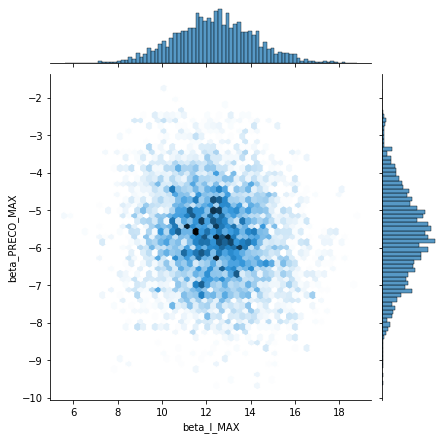

In [113]:
sns.jointplot(burned_trace['beta_I_MAX'], burned_trace['beta_PRECO_MAX'], kind="hex") #color="#4CB391")

plt.xlabel("beta_I_MAX")
plt.ylabel("beta_PRECO_MAX");

In [114]:
y_prob = np.mean(burned_trace['p'], axis=0)
y_pred = 1 * y_prob >= .5

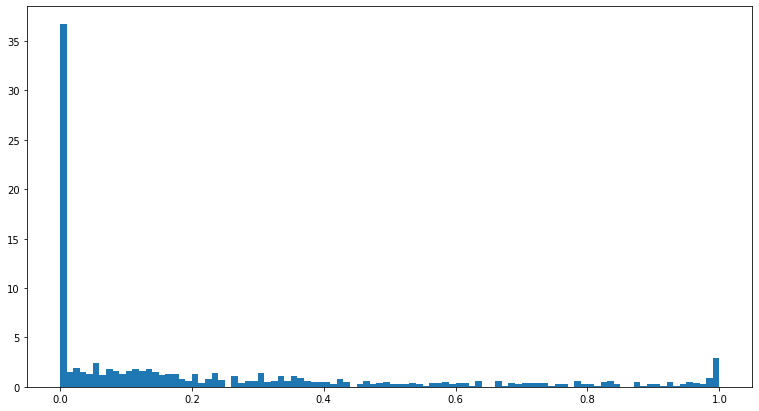

In [115]:
plt.hist(y_prob, bins=100, density=True) ; 

In [116]:
print( classification_report(yt, y_pred) )

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       666
           1       0.81      0.61      0.69       190

    accuracy                           0.88       856
   macro avg       0.85      0.78      0.81       856
weighted avg       0.88      0.88      0.87       856



In [86]:
del model_reglog

In [117]:
gc.collect()

25840

# classificador binário regularizado

In [118]:
df = pd.read_csv('~/Documents/data/cartola-fc-brasil-scouts/jogadores.csv')

df = df.sort_values(by=["ano", "rodada"]).copy()
df['id']  = df['Nome'].apply( lambda x: hashlib.sha1(str.encode(x)).hexdigest() )
df['pos'] = df['Nome'].apply( lambda x: x.split('(')[-1].split(')')[0].strip() )

display( df )

scouts  = ['DS','G','A','SG','FS','FF','FD','FT','DD','DP','GC','CV','CA','PP','GS','FC','I','PI','RB','PE']
mercado = ['Preço', 'Média','Variação']
keys    = ["id", "ano"]

gscouts = df.groupby(keys)[scouts].agg(['max'])
gscouts.columns = gscouts.columns.map('_'.join)
gscouts = gscouts.reset_index()

gmercado = df.groupby(keys)[mercado].agg(['max'])
gmercado.columns = gmercado.columns.map('_'.join)
gmercado = gmercado.reset_index()

gpos = df.groupby(keys)[['pos']].agg(['first'])
gpos.columns = gpos.columns.map('_'.join)
gpos = gpos.reset_index()

display(gpos['pos_first'].value_counts())

Nome         Clube  Preço    J  Média  Últ. Pont.  \
7882     Ricardo Bueno (ATA)         Ceará  18.52  1.0  22.70        22.7   
7883    Bruno Henrique (ATA)      Flamengo  21.51  1.0  21.00        21.0   
7884             Nikão (MEI)  Athlético-PR  19.29  1.0  18.80        18.8   
7885             Tiepo (GOL)   Chapecoense  13.18  1.0  17.00        17.0   
7886         Vanderlei (GOL)        Santos  22.69  1.0  15.70        15.7   
...                      ...           ...    ...  ...    ...         ...   
7877            Jadson (MEI)  Athlético-PR   3.53  9.0   0.11         0.8   
7878  Patrick de Lucca (MEI)         Bahia   0.77  3.0  -0.23        -1.5   
7879    Guilherme Biro (ATA)      Coritiba   0.77  8.0  -0.32        -3.6   
7880   Gabriel Pereira (MEI)   Corinthians   0.79  5.0  -0.40         0.0   
7881        Wellington (LAT)     São Paulo   0.77  1.0  -3.10        -3.1   

      Variação    DS    G    A  ...   GS    FC    I    PI  rodada   ano   RB  \
7882     14.52   NaN  2.0  1.0  ...  NaN   2.0  1.0   NaN       1  2019  1.0   
7883     11.51   NaN  2.0  NaN  ...  NaN   1.0  NaN   NaN       1  2019  NaN   
7884     10.29   NaN  1.0  NaN  ...  NaN   1.0  NaN   NaN       1  2019  5.0   
7885     11.18   NaN  NaN  NaN  ...  NaN   NaN  NaN   NaN       1  2019  NaN   
7886      5.69   NaN  NaN  NaN  ...  1.0   NaN  NaN   NaN       1  2019  NaN   
...        ...   ...  ...  ...  ...  ...   ...  ...   ...     ...   ...  ...   
7877     -0.40   NaN  NaN  NaN  ...  NaN   3.0  NaN  40.0      38  2020  NaN   
7878     -0.29   1.0  NaN  NaN  ...  NaN   NaN  NaN  25.0      38  2020  NaN   
7879     -0.21  15.0  NaN  NaN  ...  NaN  14.0  NaN  41.0      38  2020  NaN   
7880      0.00   1.0  NaN  NaN  ...  NaN   6.0  NaN  15.0      38  2020  NaN   
7881     -0.23   NaN  NaN  NaN  ...  NaN   4.0  NaN   1.0      38  2020  NaN   

       PE                                        id  pos  
7882  1.0  1f4d452190fb0558c5f5696b944b9afe4b02ca08  ATA  
7883  NaN  9f9a076464350d81d76c9b8940d64b9890e4b053  ATA  
7884  NaN  9752a812f300239c0f4fcae95d41e2843653a308  MEI  
7885  NaN  ec9799d86e28ec368cccfb660bf39ff3bc3eed7c  GOL  
7886  1.0  a5dde5accc0044a9808b0257f6faa5ba89342b7f  GOL  
...   ...                                       ...  ...  
7877  NaN  fe95e28e44efa7db07376c045a2fa89332ea5308  MEI  
7878  NaN  0157594398527348fc28f663c44291f22f8172ae  MEI  
7879  NaN  3e299fb9c705d57573fa4ab8a1a9f607edc60dc2  ATA  
7880  NaN  90a8b33c4ac288f85fa4a7e678592dd30600d8a4  MEI  
7881  NaN  e56896e9bd7426de5236ee5280c369328818c6c3  LAT  

[16404 rows x 31 columns]

MEI    408
ATA    285
ZAG    203
LAT    200
GOL     96
TEC     91
Name: pos_first, dtype: int64

In [119]:
cols_ = ["Preço_max", "Média_max", "Variação_max", "G_max", "A_max", "I_max", "GC_max", "FC_max", "pos_first"]
X = pd.concat([gscouts.drop(columns=keys), gmercado.drop(columns=keys), gpos.drop(columns=keys)], axis=1).copy().fillna(-1.0)#[cols_]
X.columns = X.columns.str.upper()

In [120]:
scaler = StandardScaler()
scaler = MinMaxScaler()

yy = pd.Categorical(1 * X["POS_FIRST"] == "ATA").codes
# yy = pd.Categorical(X["POS_FIRST"])
xx = scaler.fit_transform( X.drop(columns=["POS_FIRST"]) )

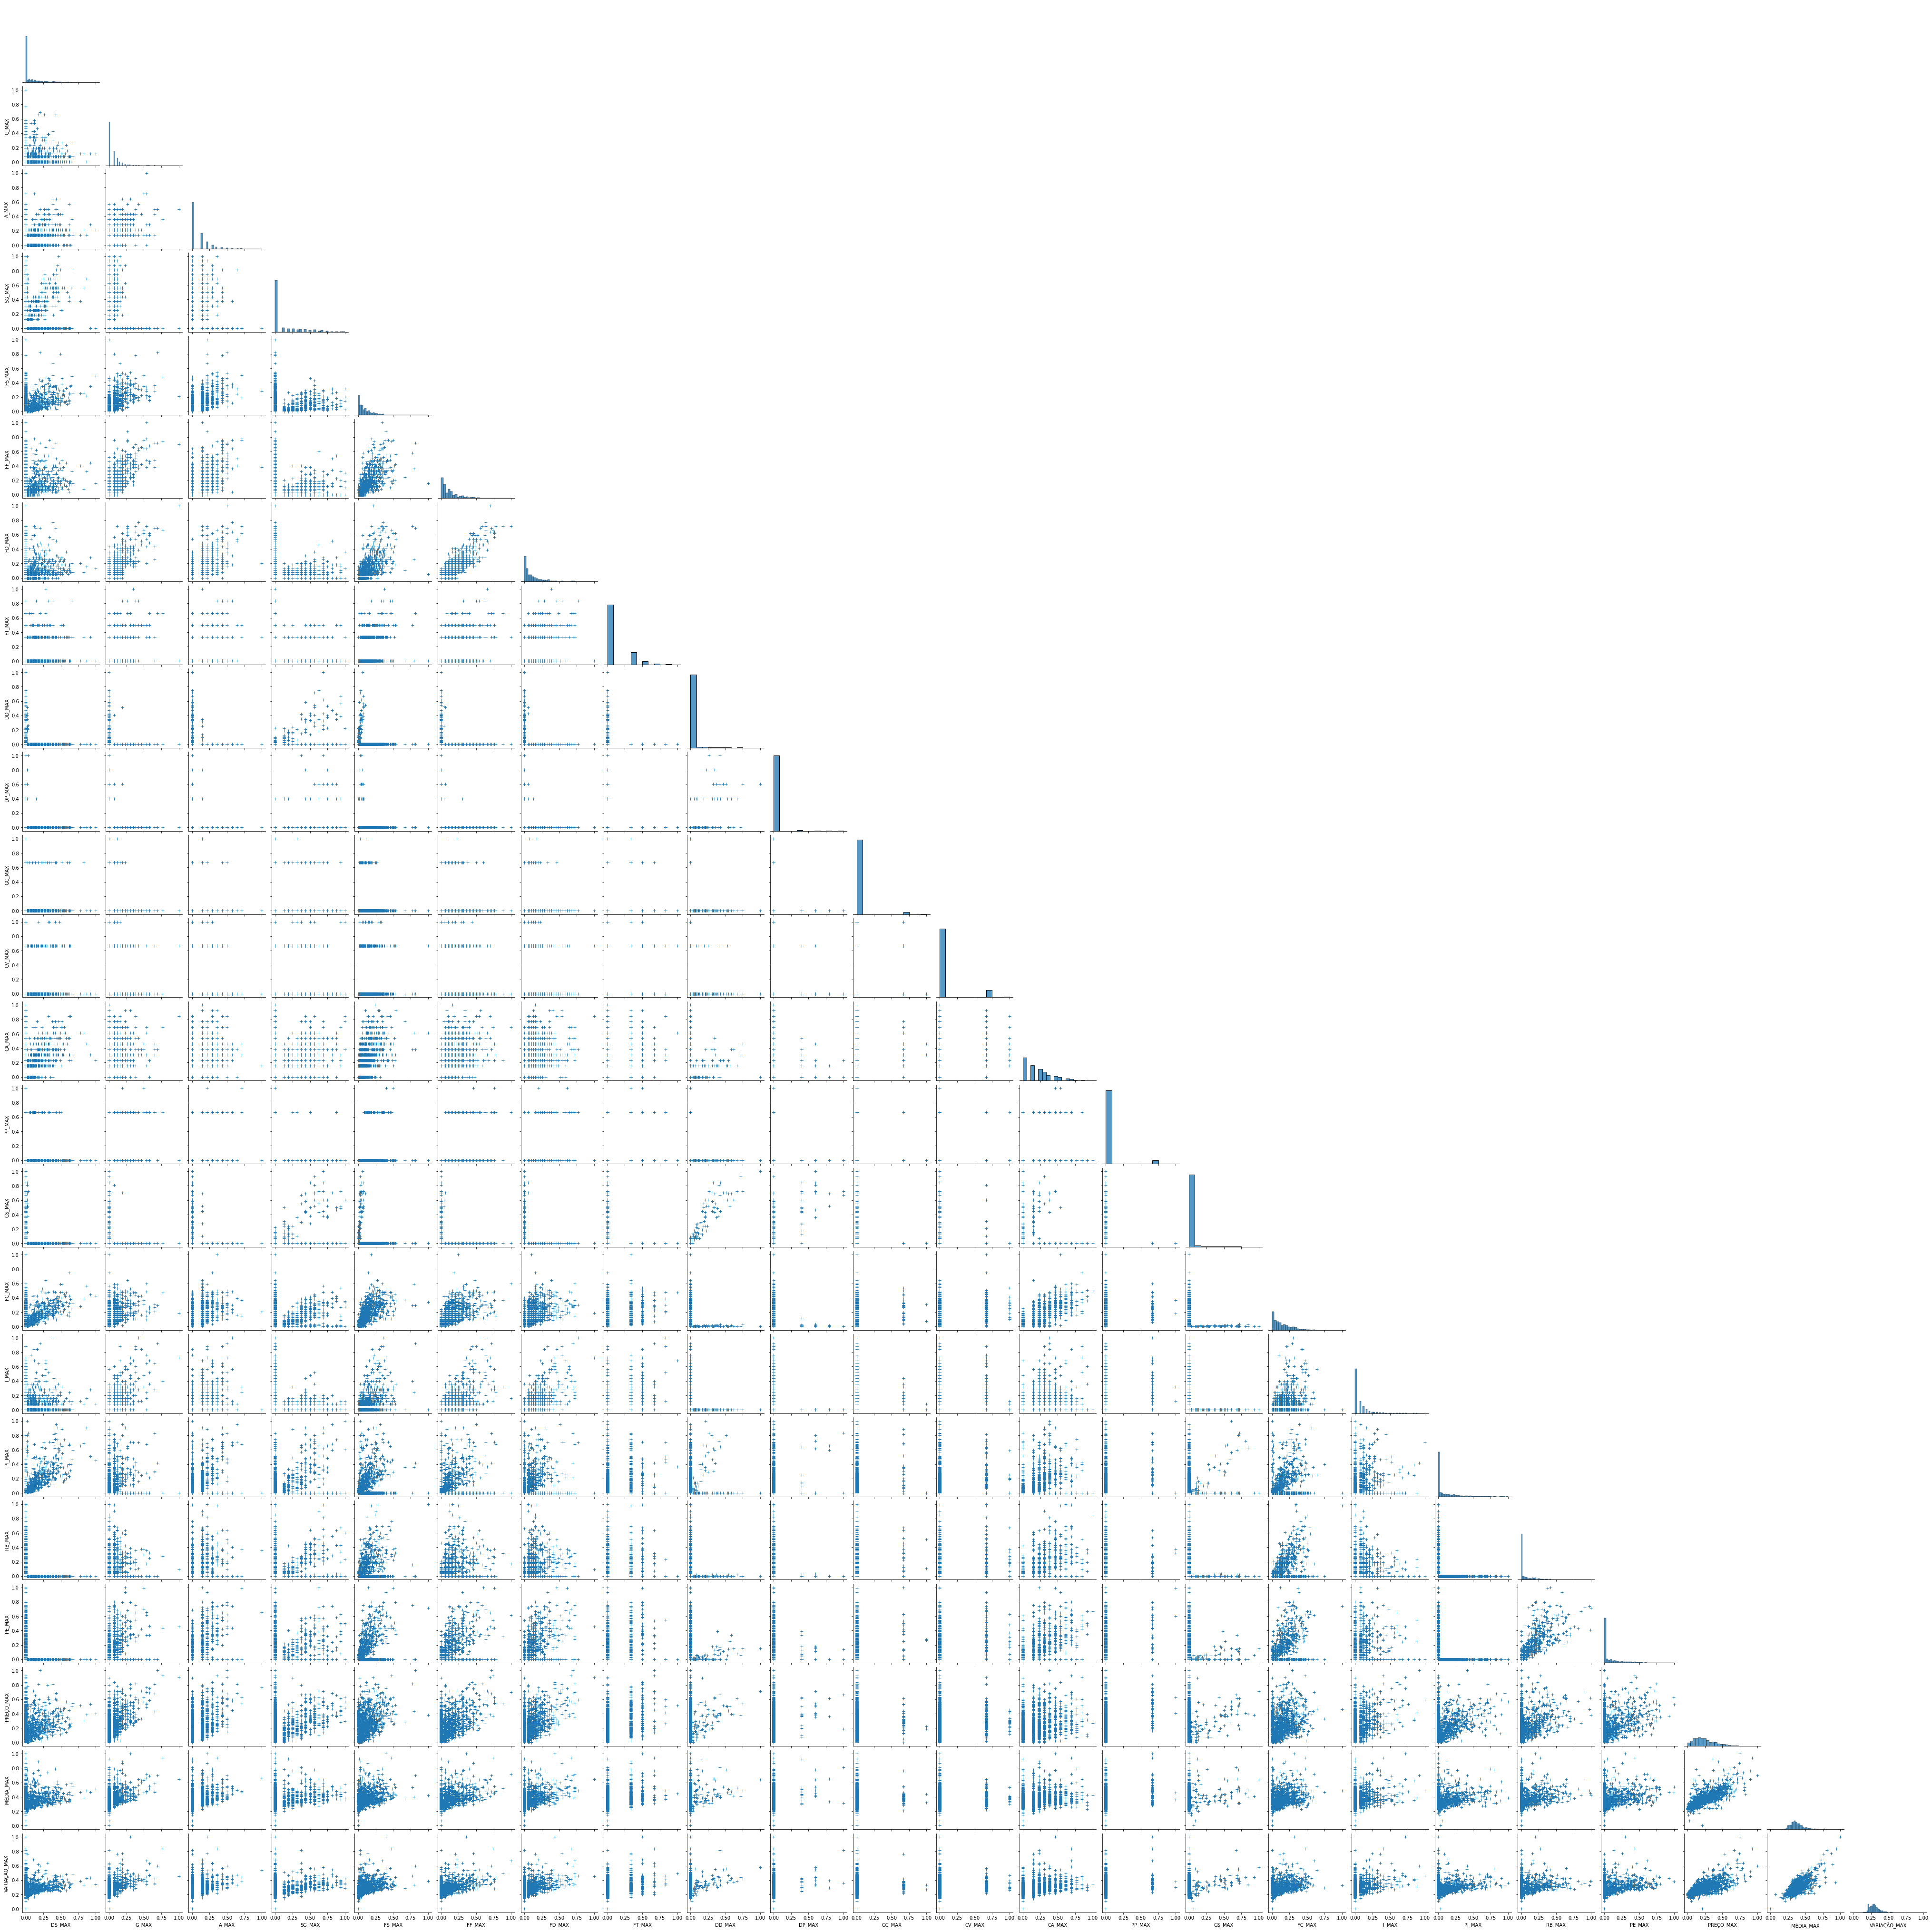

In [121]:
x_ = X.drop(columns=["POS_FIRST"]).copy()
x_[x_.columns] = scaler.fit_transform( x_ )

g = sns.pairplot(x_, corner=True, plot_kws=dict(marker="+", linewidth=1),)

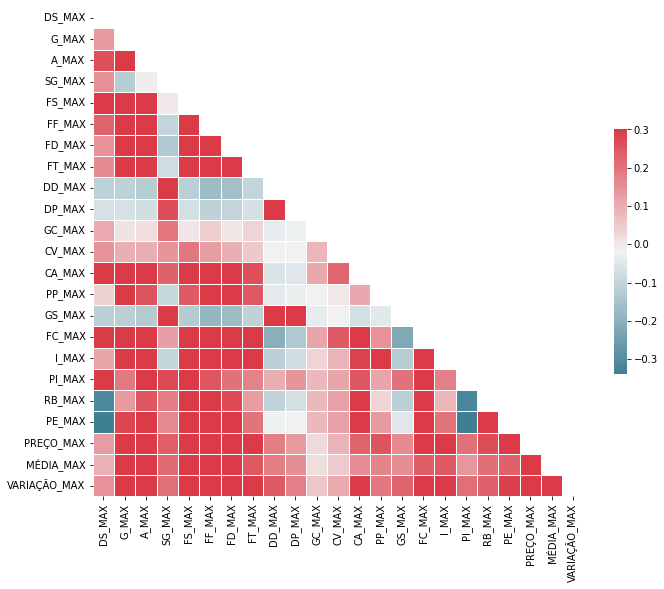

In [122]:
corr = x_.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
);

In [123]:
gc.collect()

1303292

## seleção

In [124]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=10, n_estimators=500, oob_score=True)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, max_iter=23)

feat_selector.fit(x_.values, yy)

Iteration: 	1 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 23
Confirmed: 	11
Tentative: 	4
Rejected: 	8
Iteration: 	9 / 23
Confirmed: 	11
Tentative: 	4
Rejected: 	8
Iteration: 	10 / 23
Confirmed: 	11
Tentative: 	4
Rejected: 	8
Iteration: 	11 / 23
Confirmed: 	11
Tentative: 	4
Rejected: 	8
Iteration: 	12 / 23
Confirmed: 	11
Tentative: 	3
Rejected: 	9
Iteration: 	13 / 23
Confirmed: 	11
Tentative: 	3
Rejected: 	9
Iteration: 	14 / 23
Confirmed: 	11
Tentative: 	3
Rejected: 	9
Iteration: 	15 / 23
Confirmed: 	11
Tentative: 	3
Rejected: 	9
Iteration: 	16 / 23
Confirmed: 	12
Tentative: 	2
Rejected: 	9
Iteration: 	17 / 

BorutaPy(estimator=RandomForestClassifier(max_depth=10, n_estimators=52,
                                          n_jobs=-1, oob_score=True,
                                          random_state=RandomState(MT19937) at 0x7F3E2A039C40),
         max_iter=23, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F3E2A039C40, verbose=2)

In [125]:
accept = x_.columns[feat_selector.support_].to_list()
irresolution = x_.columns[feat_selector.support_weak_].to_list()

In [126]:
xx_ = feat_selector.transform(x_.values)

print('Accepted features:')
print('----------------------------')
print(list(accept))
print('----------------------------')
print(list(irresolution))

Accepted features:
----------------------------
['DS_MAX', 'G_MAX', 'SG_MAX', 'FS_MAX', 'FF_MAX', 'FD_MAX', 'CA_MAX', 'FC_MAX', 'I_MAX', 'RB_MAX', 'PREÇO_MAX', 'VARIAÇÃO_MAX']
----------------------------
['PI_MAX', 'MÉDIA_MAX']


In [127]:
gc.collect()

144

## modelo

+ $ \theta = \sigma( \alpha + x\beta) $
+ $ y \sim Bern(\theta) $

$$ p = logit\left( \beta_0 + \sum_{c}\beta_{c}X_c\right)$$

In [128]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

for train_index, test_index in skf.split(x_[accept], yy):
    Xt, Xh = x_.iloc[train_index][accept], x_.iloc[test_index][accept]
    yt, yh = yy[train_index], yy[test_index]
    
    print(Xt.shape, Xh.shape, yt.shape, yh.shape)

(855, 12) (428, 12) (855,) (428,)
(855, 12) (428, 12) (855,) (428,)
(856, 12) (427, 12) (856,) (427,)


In [130]:
lower  = -10**6
higher = 10**6

sigma2 = 1.0
b = 1.0 / np.sqrt(2.0 * sigma2)

In [135]:
for c in Xt.columns:
    print(rf"""beta_{c} = pm.Laplace("beta_{c}", mu=0, b=b)""".replace("Ç", "C").replace("É", "E").replace("Ã", "A"))

beta_DS_MAX = pm.Laplace("beta_DS_MAX", mu=0, b=b)
beta_G_MAX = pm.Laplace("beta_G_MAX", mu=0, b=b)
beta_SG_MAX = pm.Laplace("beta_SG_MAX", mu=0, b=b)
beta_FS_MAX = pm.Laplace("beta_FS_MAX", mu=0, b=b)
beta_FF_MAX = pm.Laplace("beta_FF_MAX", mu=0, b=b)
beta_FD_MAX = pm.Laplace("beta_FD_MAX", mu=0, b=b)
beta_CA_MAX = pm.Laplace("beta_CA_MAX", mu=0, b=b)
beta_FC_MAX = pm.Laplace("beta_FC_MAX", mu=0, b=b)
beta_I_MAX = pm.Laplace("beta_I_MAX", mu=0, b=b)
beta_RB_MAX = pm.Laplace("beta_RB_MAX", mu=0, b=b)
beta_PRECO_MAX = pm.Laplace("beta_PRECO_MAX", mu=0, b=b)
beta_VARIACAO_MAX = pm.Laplace("beta_VARIACAO_MAX", mu=0, b=b)


In [103]:
for c in Xt.columns:
    print(rf"""beta_{c.replace("Ç", "C").replace("É", "E").replace("Ã", "A")} * Xt["{c}"] +""")

beta_DS_MAX * Xt["DS_MAX"] +
beta_G_MAX * Xt["G_MAX"] +
beta_SG_MAX * Xt["SG_MAX"] +
beta_FS_MAX * Xt["FS_MAX"] +
beta_FF_MAX * Xt["FF_MAX"] +
beta_FD_MAX * Xt["FD_MAX"] +
beta_CA_MAX * Xt["CA_MAX"] +
beta_FC_MAX * Xt["FC_MAX"] +
beta_I_MAX * Xt["I_MAX"] +
beta_RB_MAX * Xt["RB_MAX"] +
beta_PRECO_MAX * Xt["PREÇO_MAX"] +
beta_VARIACAO_MAX * Xt["VARIAÇÃO_MAX"] +


In [132]:
try:
    del model_reglog
except:
    pass

In [136]:
with pm.Model() as model_reglog:    
    beta_0 = pm.Uniform("beta_0", lower=lower, upper=higher)
    beta_DS_MAX = pm.Laplace("beta_DS_MAX", mu=0, b=b)
    beta_G_MAX = pm.Laplace("beta_G_MAX", mu=0, b=b)
    beta_SG_MAX = pm.Laplace("beta_SG_MAX", mu=0, b=b)
    beta_FS_MAX = pm.Laplace("beta_FS_MAX", mu=0, b=b)
    beta_FF_MAX = pm.Laplace("beta_FF_MAX", mu=0, b=b)
    beta_FD_MAX = pm.Laplace("beta_FD_MAX", mu=0, b=b)
    beta_CA_MAX = pm.Laplace("beta_CA_MAX", mu=0, b=b)
    beta_FC_MAX = pm.Laplace("beta_FC_MAX", mu=0, b=b)
    beta_I_MAX = pm.Laplace("beta_I_MAX", mu=0, b=b)
    beta_RB_MAX = pm.Laplace("beta_RB_MAX", mu=0, b=b)
    beta_PRECO_MAX = pm.Laplace("beta_PRECO_MAX", mu=0, b=b)
    beta_VARIACAO_MAX = pm.Laplace("beta_VARIACAO_MAX", mu=0, b=b)
    
    p = pm.Deterministic(
        "p",
        pm.math.sigmoid(
            beta_0 + 
            beta_DS_MAX * Xt["DS_MAX"] +
            beta_G_MAX * Xt["G_MAX"] +
            beta_SG_MAX * Xt["SG_MAX"] +
            beta_FS_MAX * Xt["FS_MAX"] +
            beta_FF_MAX * Xt["FF_MAX"] +
            beta_FD_MAX * Xt["FD_MAX"] +
            beta_CA_MAX * Xt["CA_MAX"] +
            beta_FC_MAX * Xt["FC_MAX"] +
            beta_I_MAX * Xt["I_MAX"] +
            beta_RB_MAX * Xt["RB_MAX"] +
            beta_PRECO_MAX * Xt["PREÇO_MAX"] +
            beta_VARIACAO_MAX * Xt["VARIAÇÃO_MAX"]
        )
    )

In [137]:
with model_reglog:
    observed = pm.Bernoulli("target", p, observed=yt)
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    n_ = 20000
    trace = pm.sample(n_, step=step, start=start)
    burned_trace = trace[int(0.75 * n_):]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_VARIACAO_MAX]
>Metropolis: [beta_PRECO_MAX]
>Metropolis: [beta_RB_MAX]
>Metropolis: [beta_I_MAX]
>Metropolis: [beta_FC_MAX]
>Metropolis: [beta_CA_MAX]
>Metropolis: [beta_FD_MAX]
>Metropolis: [beta_FF_MAX]
>Metropolis: [beta_FS_MAX]
>Metropolis: [beta_SG_MAX]
>Metropolis: [beta_G_MAX]
>Metropolis: [beta_DS_MAX]
>Metropolis: [beta_0]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 53 seconds.
The number of effective samples is smaller than 10% for some parameters.


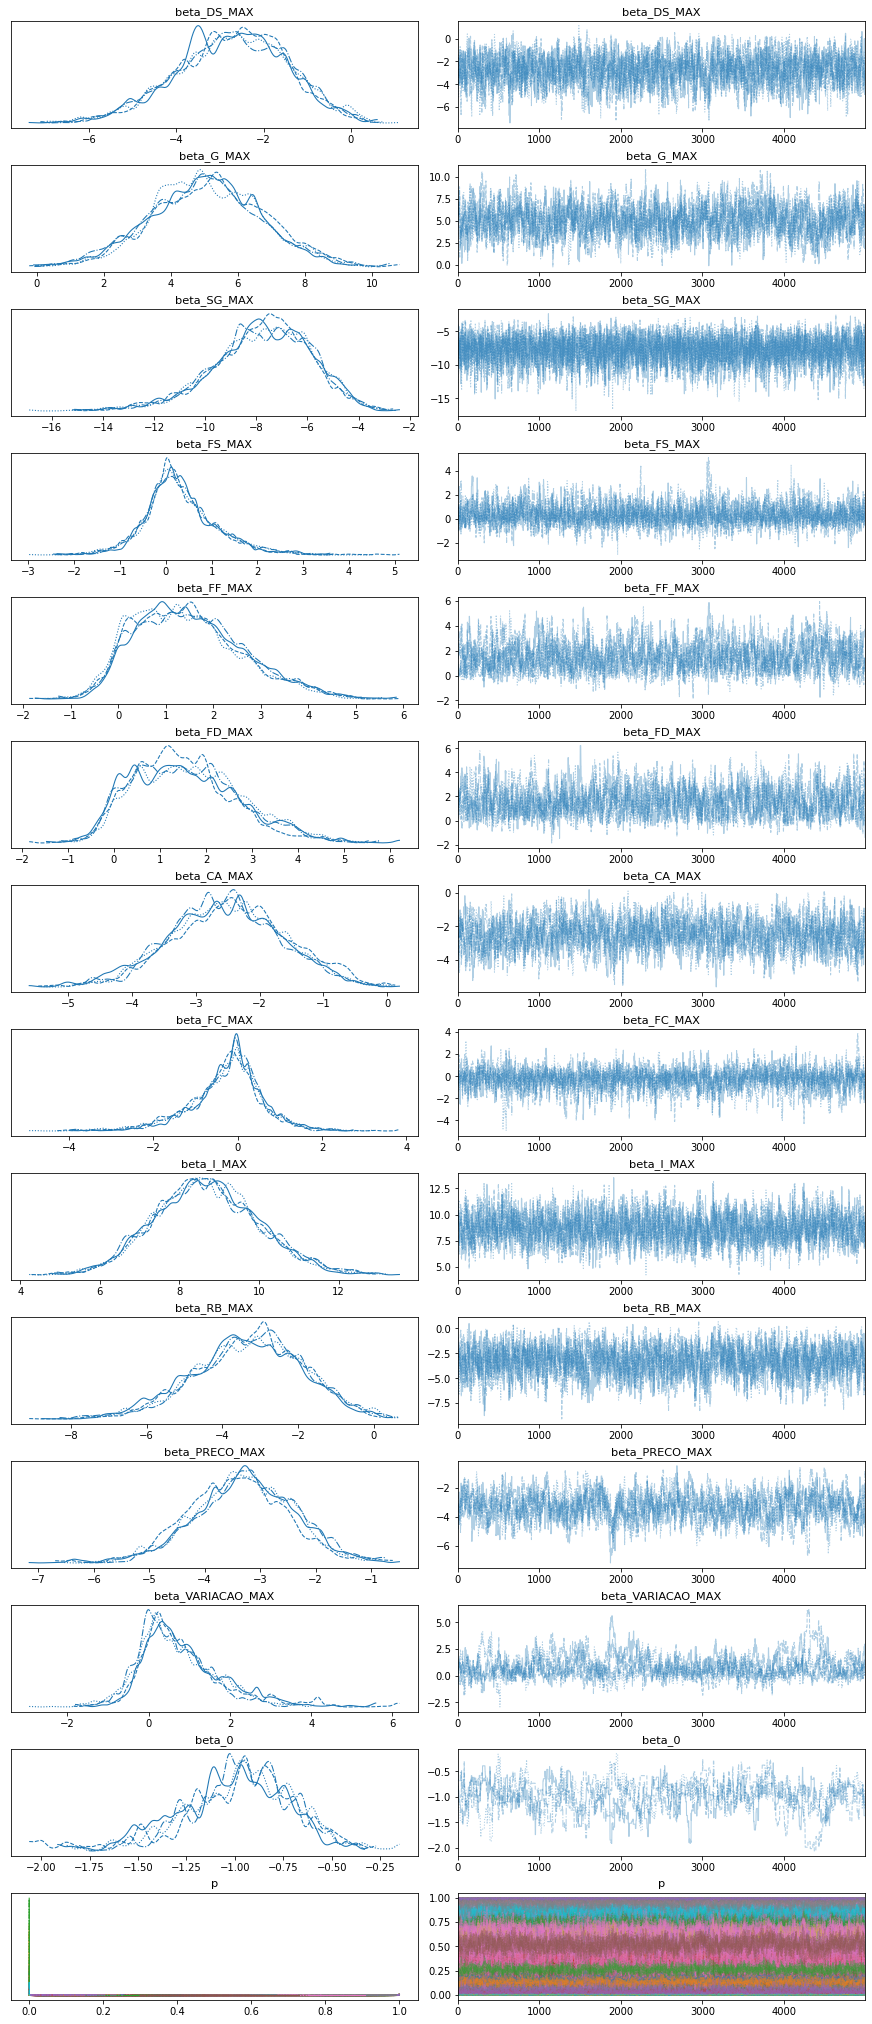

In [138]:
pm.traceplot(burned_trace) 
plt.show()

In [139]:
gc.collect()

924037

In [140]:
for c in Xt.columns:
    print(rf""" 'beta_{c.replace("Ç", "C").replace("É", "E").replace("Ã", "A")}' """)

 'beta_DS_MAX' 
 'beta_G_MAX' 
 'beta_SG_MAX' 
 'beta_FS_MAX' 
 'beta_FF_MAX' 
 'beta_FD_MAX' 
 'beta_CA_MAX' 
 'beta_FC_MAX' 
 'beta_I_MAX' 
 'beta_RB_MAX' 
 'beta_PRECO_MAX' 
 'beta_VARIACAO_MAX' 


In [141]:
coeffs = ['beta_0',
 'beta_DS_MAX' ,
 'beta_G_MAX' ,
 'beta_SG_MAX' ,
 'beta_FS_MAX' ,
 'beta_FF_MAX' ,
 'beta_FD_MAX' ,
 'beta_CA_MAX' ,
 'beta_FC_MAX' ,
 'beta_I_MAX' ,
 'beta_RB_MAX' ,
 'beta_PRECO_MAX' ,
 'beta_VARIACAO_MAX' 
 ]

In [142]:
d = dict()

for item in coeffs:
    d[item] = [burned_trace[item].mean()]

In [144]:
result_coeffs=pd.DataFrame.from_dict(d)    
result_coeffs

beta_0  beta_DS_MAX  beta_G_MAX  beta_SG_MAX  beta_FS_MAX  beta_FF_MAX  \
0 -0.986446    -2.726031    5.073788    -7.762769     0.335024     1.486073   

   beta_FD_MAX  beta_CA_MAX  beta_FC_MAX  beta_I_MAX  beta_RB_MAX  \
0     1.572082    -2.505425    -0.261698    8.687419    -3.280585   

   beta_PRECO_MAX  beta_VARIACAO_MAX  
0       -3.306078           0.755796

In [145]:
pm.stats.hdi(burned_trace['beta_0'])

interval = dict()

for item in coeffs:    
    interval[item]=pm.stats.hdi(burned_trace[item]) #compute 95% high density interval
    
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
result_coeffs

beta_0  beta_DS_MAX  beta_G_MAX  beta_SG_MAX  beta_FS_MAX  \
lower -1.536905    -5.212594    1.980061   -11.206367    -1.039428   
upper -0.476281    -0.464655    8.235269    -4.111313     2.051258   

       beta_FF_MAX  beta_FD_MAX  beta_CA_MAX  beta_FC_MAX  beta_I_MAX  \
lower    -0.437408    -0.428017    -4.078527    -2.086866    6.194658   
upper     3.656338     3.687648    -0.769406     1.273611   11.108353   

       beta_RB_MAX  beta_PRECO_MAX  beta_VARIACAO_MAX  
lower    -6.107309       -5.029424          -0.895810  
upper    -0.738253       -1.680450           2.753457

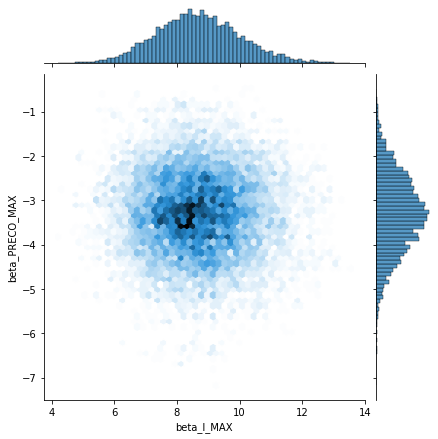

In [146]:
sns.jointplot(burned_trace['beta_I_MAX'], burned_trace['beta_PRECO_MAX'], kind="hex") #color="#4CB391")

plt.xlabel("beta_I_MAX")
plt.ylabel("beta_PRECO_MAX");

In [147]:
y_prob = np.mean(burned_trace['p'], axis=0)
y_pred = 1 * y_prob >= .5

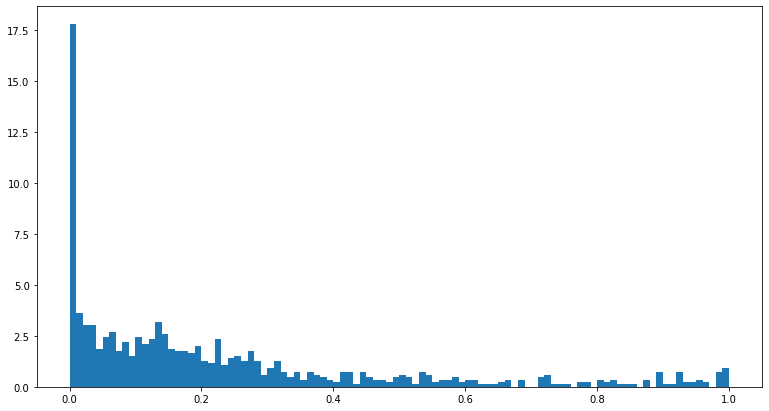

In [148]:
plt.hist(y_prob, bins=100, density=True) ; 

In [149]:
print( classification_report(yt, y_pred) )

              precision    recall  f1-score   support

           0       0.88      0.97      0.93       666
           1       0.86      0.54      0.66       190

    accuracy                           0.88       856
   macro avg       0.87      0.76      0.79       856
weighted avg       0.88      0.88      0.87       856



In [86]:
del model_reglog

In [117]:
gc.collect()

25840

# classificador multiclasse regularizado

In [8]:
df = pd.read_csv('~/Documents/data/cartola-fc-brasil-scouts/jogadores.csv')

df = df.sort_values(by=["ano", "rodada"]).copy()
df['id']  = df['Nome'].apply( lambda x: hashlib.sha1(str.encode(x)).hexdigest() )
df['pos'] = df['Nome'].apply( lambda x: x.split('(')[-1].split(')')[0].strip() )

display( df )

scouts  = ['DS','G','A','SG','FS','FF','FD','FT','DD','DP','GC','CV','CA','PP','GS','FC','I','PI','RB','PE']
mercado = ['Preço', 'Média','Variação']
keys    = ["id", "ano"]

gscouts = df.groupby(keys)[scouts].agg(['max'])
gscouts.columns = gscouts.columns.map('_'.join)
gscouts = gscouts.reset_index()

gmercado = df.groupby(keys)[mercado].agg(['max'])
gmercado.columns = gmercado.columns.map('_'.join)
gmercado = gmercado.reset_index()

gpos = df.groupby(keys)[['pos']].agg(['first'])
gpos.columns = gpos.columns.map('_'.join)
gpos = gpos.reset_index()

display(gpos['pos_first'].value_counts())

Nome         Clube  Preço    J  Média  Últ. Pont.  \
7882     Ricardo Bueno (ATA)         Ceará  18.52  1.0  22.70        22.7   
7883    Bruno Henrique (ATA)      Flamengo  21.51  1.0  21.00        21.0   
7884             Nikão (MEI)  Athlético-PR  19.29  1.0  18.80        18.8   
7885             Tiepo (GOL)   Chapecoense  13.18  1.0  17.00        17.0   
7886         Vanderlei (GOL)        Santos  22.69  1.0  15.70        15.7   
...                      ...           ...    ...  ...    ...         ...   
7877            Jadson (MEI)  Athlético-PR   3.53  9.0   0.11         0.8   
7878  Patrick de Lucca (MEI)         Bahia   0.77  3.0  -0.23        -1.5   
7879    Guilherme Biro (ATA)      Coritiba   0.77  8.0  -0.32        -3.6   
7880   Gabriel Pereira (MEI)   Corinthians   0.79  5.0  -0.40         0.0   
7881        Wellington (LAT)     São Paulo   0.77  1.0  -3.10        -3.1   

      Variação    DS    G    A  ...   GS    FC    I    PI  rodada   ano   RB  \
7882     14.52   NaN  2.0  1.0  ...  NaN   2.0  1.0   NaN       1  2019  1.0   
7883     11.51   NaN  2.0  NaN  ...  NaN   1.0  NaN   NaN       1  2019  NaN   
7884     10.29   NaN  1.0  NaN  ...  NaN   1.0  NaN   NaN       1  2019  5.0   
7885     11.18   NaN  NaN  NaN  ...  NaN   NaN  NaN   NaN       1  2019  NaN   
7886      5.69   NaN  NaN  NaN  ...  1.0   NaN  NaN   NaN       1  2019  NaN   
...        ...   ...  ...  ...  ...  ...   ...  ...   ...     ...   ...  ...   
7877     -0.40   NaN  NaN  NaN  ...  NaN   3.0  NaN  40.0      38  2020  NaN   
7878     -0.29   1.0  NaN  NaN  ...  NaN   NaN  NaN  25.0      38  2020  NaN   
7879     -0.21  15.0  NaN  NaN  ...  NaN  14.0  NaN  41.0      38  2020  NaN   
7880      0.00   1.0  NaN  NaN  ...  NaN   6.0  NaN  15.0      38  2020  NaN   
7881     -0.23   NaN  NaN  NaN  ...  NaN   4.0  NaN   1.0      38  2020  NaN   

       PE                                        id  pos  
7882  1.0  1f4d452190fb0558c5f5696b944b9afe4b02ca08  ATA  
7883  NaN  9f9a076464350d81d76c9b8940d64b9890e4b053  ATA  
7884  NaN  9752a812f300239c0f4fcae95d41e2843653a308  MEI  
7885  NaN  ec9799d86e28ec368cccfb660bf39ff3bc3eed7c  GOL  
7886  1.0  a5dde5accc0044a9808b0257f6faa5ba89342b7f  GOL  
...   ...                                       ...  ...  
7877  NaN  fe95e28e44efa7db07376c045a2fa89332ea5308  MEI  
7878  NaN  0157594398527348fc28f663c44291f22f8172ae  MEI  
7879  NaN  3e299fb9c705d57573fa4ab8a1a9f607edc60dc2  ATA  
7880  NaN  90a8b33c4ac288f85fa4a7e678592dd30600d8a4  MEI  
7881  NaN  e56896e9bd7426de5236ee5280c369328818c6c3  LAT  

[16404 rows x 31 columns]

MEI    408
ATA    285
ZAG    203
LAT    200
GOL     96
TEC     91
Name: pos_first, dtype: int64

In [9]:
cols_ = ["Preço_max", "Média_max", "Variação_max", "G_max", "A_max", "I_max", "GC_max", "FC_max", "pos_first"]
X = pd.concat([gscouts.drop(columns=keys), gmercado.drop(columns=keys), gpos.drop(columns=keys)], axis=1).copy().fillna(-1.0)#[cols_]
X.columns = X.columns.str.upper()

In [10]:
scaler = StandardScaler()
scaler = MinMaxScaler()

# yy = pd.Categorical(1 * X["POS_FIRST"] == "ATA").codes
yy = pd.Categorical(X["POS_FIRST"]).codes
xx = scaler.fit_transform( X.drop(columns=["POS_FIRST"]) )

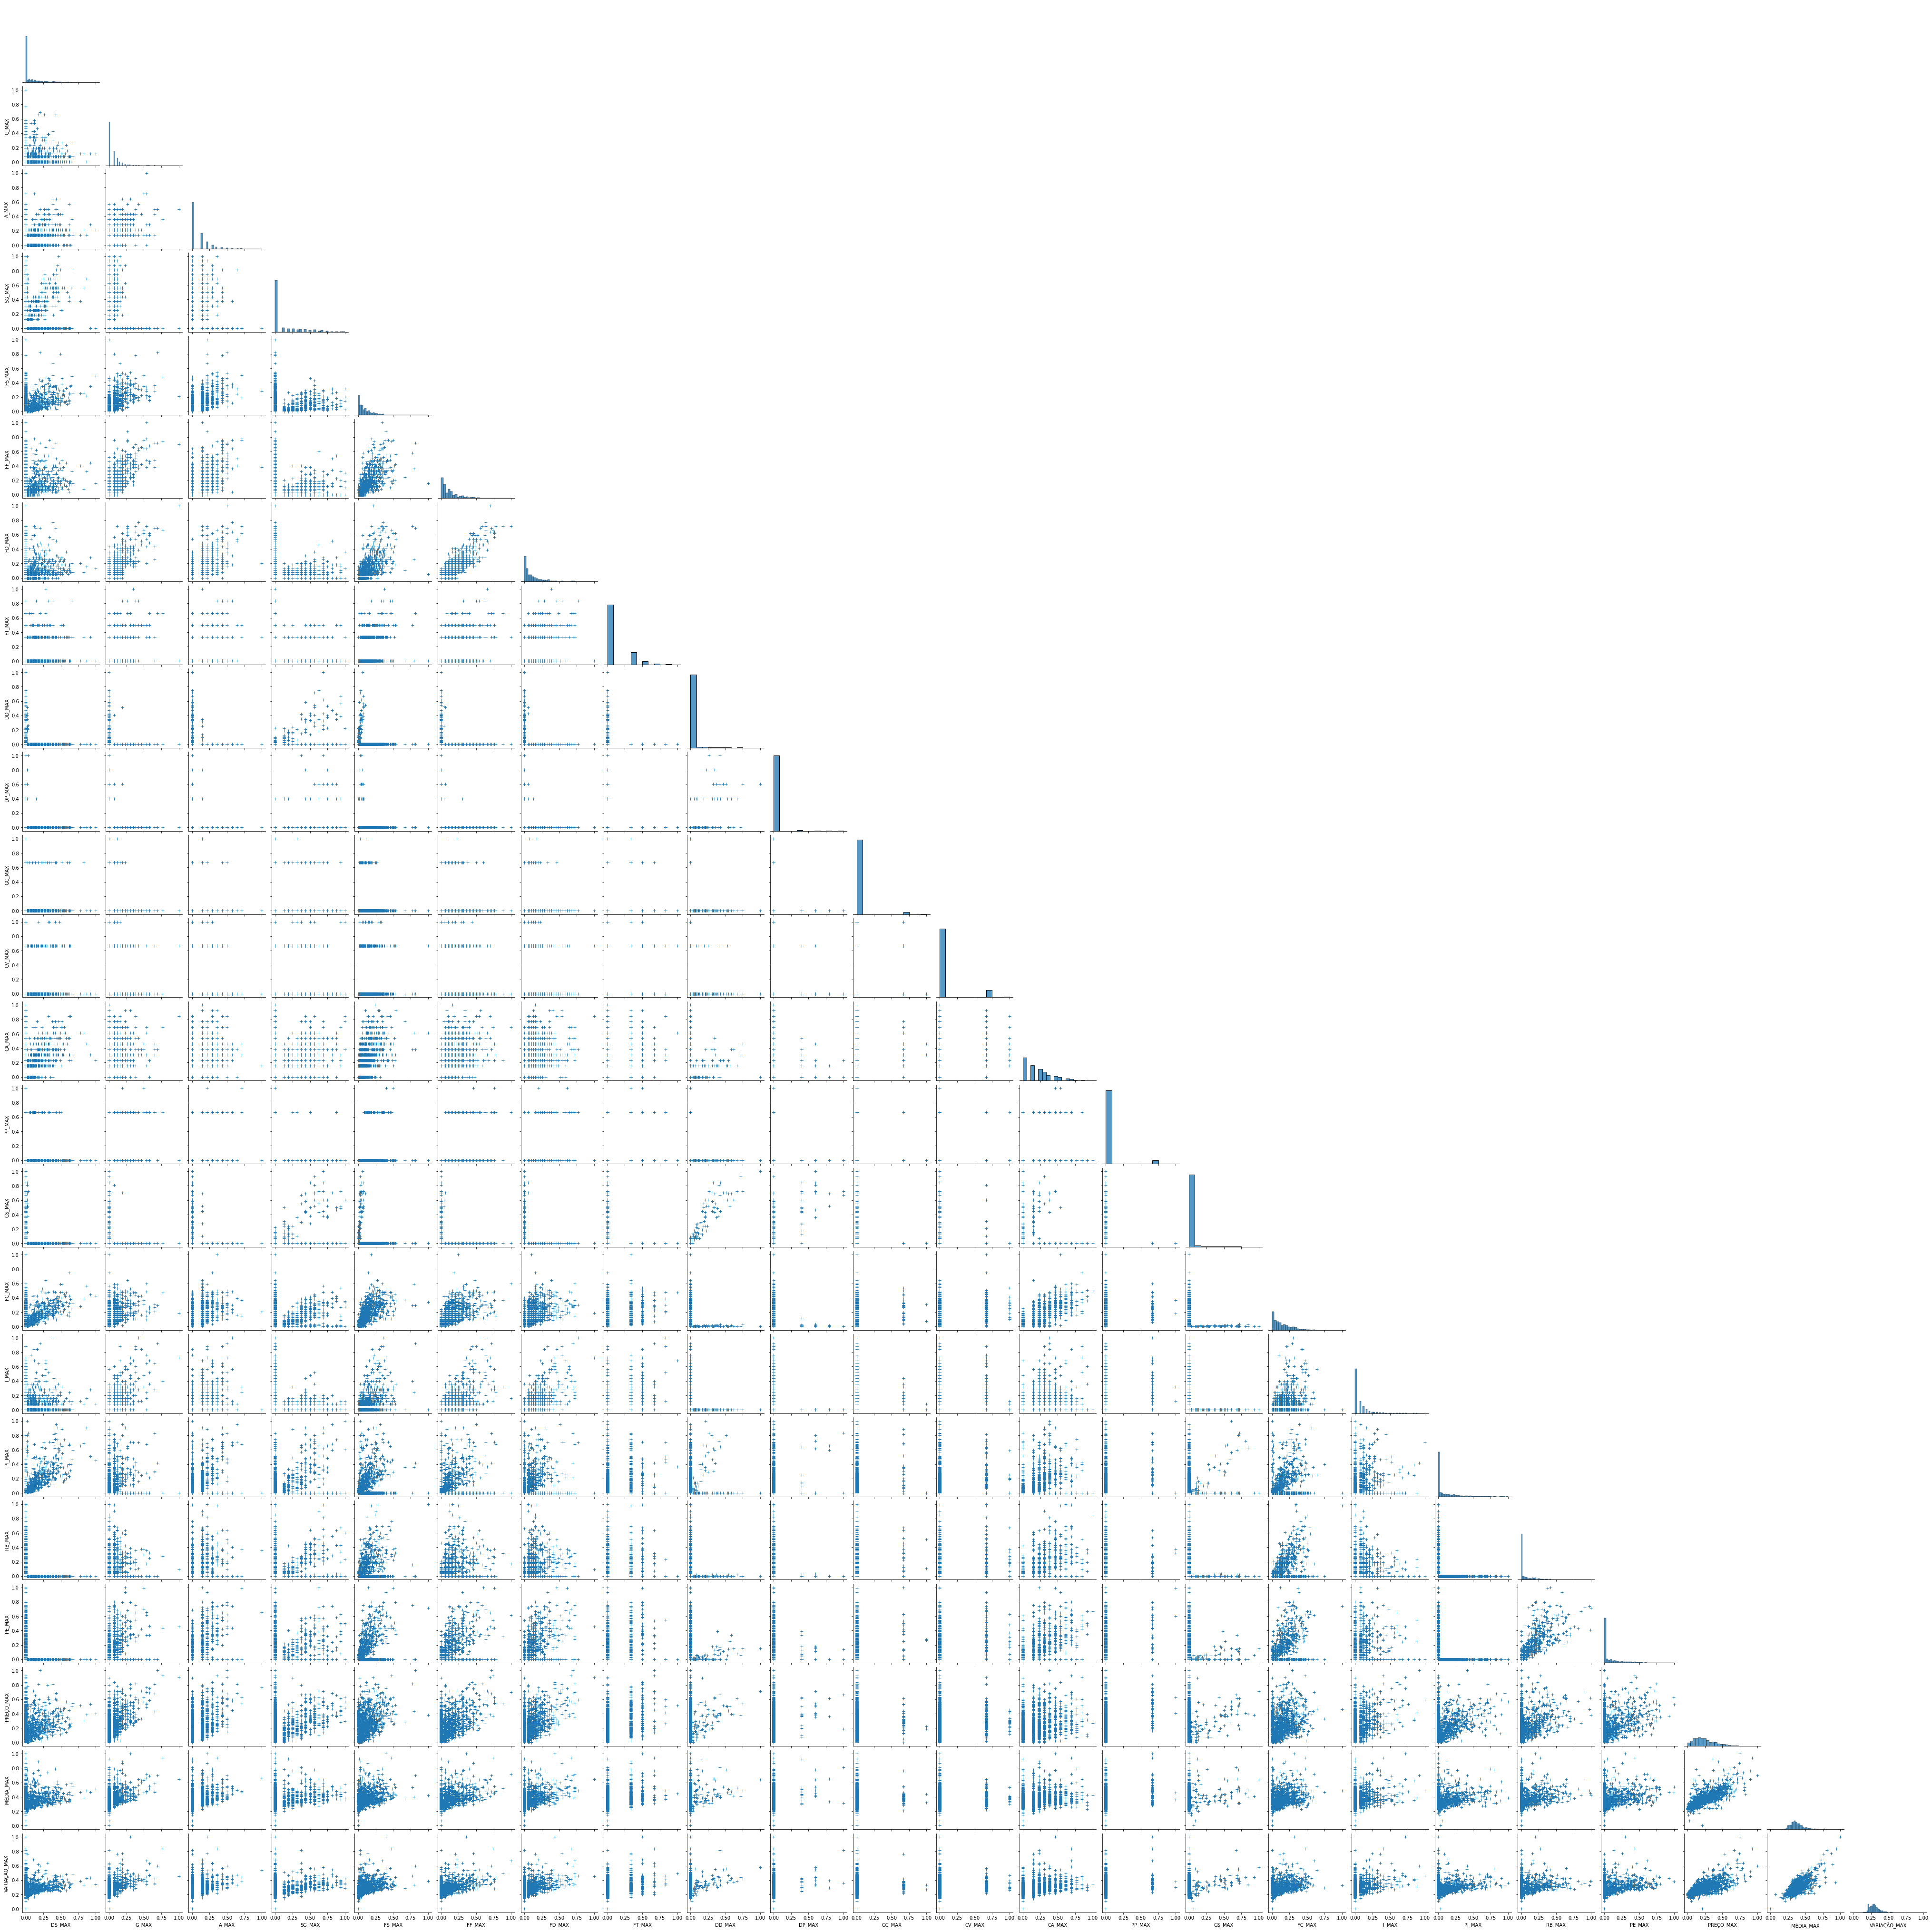

In [11]:
x_ = X.drop(columns=["POS_FIRST"]).copy()
x_[x_.columns] = scaler.fit_transform( x_ )

g = sns.pairplot(x_, corner=True, plot_kws=dict(marker="+", linewidth=1),)

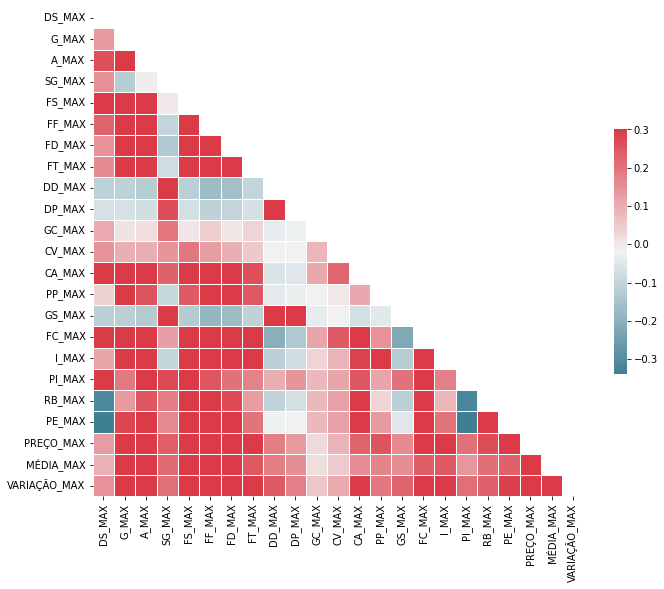

In [12]:
corr = x_.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
);

In [13]:
gc.collect()

1377

## seleção

In [14]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=10, n_estimators=500, oob_score=True)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, max_iter=23)

feat_selector.fit(x_.values, yy)

Iteration: 	1 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 23
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 23
Confirmed: 	15
Tentative: 	2
Rejected: 	6
Iteration: 	9 / 23
Confirmed: 	15
Tentative: 	2
Rejected: 	6
Iteration: 	10 / 23
Confirmed: 	15
Tentative: 	2
Rejected: 	6
Iteration: 	11 / 23
Confirmed: 	15
Tentative: 	2
Rejected: 	6
Iteration: 	12 / 23
Confirmed: 	15
Tentative: 	2
Rejected: 	6
Iteration: 	13 / 23
Confirmed: 	15
Tentative: 	2
Rejected: 	6
Iteration: 	14 / 23
Confirmed: 	15
Tentative: 	2
Rejected: 	6
Iteration: 	15 / 23
Confirmed: 	15
Tentative: 	2
Rejected: 	6
Iteration: 	16 / 23
Confirmed: 	16
Tentative: 	1
Rejected: 	6
Iteration: 	17 / 

BorutaPy(estimator=RandomForestClassifier(max_depth=10, n_estimators=58,
                                          n_jobs=-1, oob_score=True,
                                          random_state=RandomState(MT19937) at 0x7FCEF0C9FA40),
         max_iter=23, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FCEF0C9FA40, verbose=2)

In [15]:
accept = x_.columns[feat_selector.support_].to_list()
irresolution = x_.columns[feat_selector.support_weak_].to_list()

In [16]:
xx_ = feat_selector.transform(x_.values)

print('Accepted features:')
print('----------------------------')
print(list(accept))
print('----------------------------')
print(list(irresolution))

Accepted features:
----------------------------
['DS_MAX', 'G_MAX', 'SG_MAX', 'FS_MAX', 'FF_MAX', 'FD_MAX', 'DD_MAX', 'CA_MAX', 'GS_MAX', 'FC_MAX', 'I_MAX', 'PI_MAX', 'RB_MAX', 'PREÇO_MAX', 'MÉDIA_MAX', 'VARIAÇÃO_MAX']
----------------------------
[]


In [17]:
gc.collect()

264

## modelo

+ $ \theta = \sigma( \alpha + x\beta) $
+ $ y \sim Bern(\theta) $

$$ p = logit\left( \beta_0 + \sum_{c}\beta_{c}X_c\right)$$

In [18]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

for train_index, test_index in skf.split(x_[accept], yy):
    Xt, Xh = x_.iloc[train_index][accept], x_.iloc[test_index][accept]
    yt, yh = yy[train_index], yy[test_index]
    
    print(Xt.shape, Xh.shape, yt.shape, yh.shape)

(855, 16) (428, 16) (855,) (428,)
(855, 16) (428, 16) (855,) (428,)
(856, 16) (427, 16) (856,) (427,)


In [19]:
lower  = -10**6
higher = 10**6

sigma2 = 1.0
b = 1.0 / np.sqrt(2.0 * sigma2)

In [20]:
shape_ = (Xt.shape[1], len(np.unique(yt)))
shape_

(16, 6)

In [23]:
try:
    del model_reglog
except:
    pass

In [24]:
with pm.Model() as model_reglog:    
    alfa = pm.Uniform("alfa", lower=lower, upper=higher, shape=shape_[1] )
    beta = pm.Laplace("beta", mu=0, b=b, shape=shape_)
    
    mu = pm.Deterministic("mu", alfa + pm.math.dot(Xt.values, beta))
    
    p = pm.Deterministic( "p", tt.nnet.softmax(mu) )

In [25]:
with model_reglog:
    observed = pm.Categorical("target", p, observed=yt)
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    n_ = 100
#     trace = pm.sample(n_, step=step, start=start)
    trace = pm.sample(n_, step=step, start={"alfa":np.zeros(shape_[1]), "beta":np.zeros(shape_)})
    burned_trace = trace[int(0.75 * n_):]

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alfa]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 1 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
# pm.traceplot(burned_trace) 
# plt.show()

In [53]:
gc.collect()

2691

In [52]:
pd.DataFrame(burned_trace["beta"].mean(0).T, columns=Xt.columns)

DS_MAX     G_MAX    SG_MAX    FS_MAX    FF_MAX    FD_MAX    DD_MAX  \
0 -0.656912  3.320902 -4.607992  2.529944  3.005134  1.924001 -1.438311   
1 -1.917204 -0.251177  2.917802 -0.993893 -1.268148 -1.866663  2.179097   
2  0.424024  0.082593  4.856289  0.328594 -0.777614 -0.364070 -1.065822   
3  1.544087  1.603550 -8.402264  2.024755  1.287547  1.803091 -0.506748   
4 -0.715685 -1.273991 -2.349324 -1.611616 -1.390618 -1.912049 -1.522149   
5  1.320978  0.056591  6.417258 -2.047638 -0.211293 -1.036678 -0.307277   

     CA_MAX    GS_MAX    FC_MAX     I_MAX    PI_MAX    RB_MAX  PREÇO_MAX  \
0  0.206716 -0.317814 -0.486056  7.441372 -1.224432 -1.724166  -0.824514   
1 -1.640236  6.617869 -1.332498 -1.708082  0.931975 -1.543305   0.636328   
2 -0.462251 -1.170879  0.311337  1.136512  2.597096  1.730260  -0.746674   
3  1.574857 -0.695611  3.425515 -0.878889  0.081377  2.351558   0.220166   
4 -2.829515 -1.222937 -2.920793 -1.446888 -2.213969 -0.497132   4.988406   
5  1.458578 -1.161418 -0.663098 -0.868272 -0.794893  0.091432  -0.416972   

   MÉDIA_MAX  VARIAÇÃO_MAX  
0   0.101384     -0.481681  
1  -0.745933      0.278016  
2  -0.427491     -0.941328  
3  -0.219122     -1.740840  
4  -1.068072      0.008947  
5  -1.117874     -2.212482

In [55]:
pd.DataFrame(burned_trace["alfa"].mean(0).T, columns=["alfa"])

alfa
0  0.355179
1 -0.352671
2  0.223608
3  0.937815
4 -0.076749
5  0.717468

In [41]:
y_prob = burned_trace['mu'].mean(0)
y_pred = [ np.exp(pp)/np.sum(np.exp(pp), axis=0) for pp in y_prob ]
y_pred = np.argmax(y_pred, axis=1)

In [43]:
print( classification_report(yt, y_pred) )

              precision    recall  f1-score   support

           0       0.77      0.63      0.69       190
           1       1.00      0.69      0.81        64
           2       0.75      0.47      0.58       134
           3       0.68      0.88      0.77       272
           4       0.84      0.93      0.88        60
           5       0.66      0.74      0.69       136

    accuracy                           0.73       856
   macro avg       0.78      0.72      0.74       856
weighted avg       0.74      0.73      0.72       856



In [56]:
h_pred = burned_trace['alfa'].mean(0) + np.dot(Xh, burned_trace['beta'].mean(0))

In [58]:
h_prob = np.exp(h_pred).T/np.sum(np.exp(h_pred), axis=1)

In [59]:
h_pred = np.argmax(h_prob, axis=0)

In [60]:
print( classification_report(yh, h_pred) )

              precision    recall  f1-score   support

           0       0.77      0.61      0.68        95
           1       1.00      0.75      0.86        32
           2       0.74      0.47      0.57        66
           3       0.65      0.88      0.75       136
           4       0.91      1.00      0.95        31
           5       0.63      0.64      0.64        67

    accuracy                           0.72       427
   macro avg       0.78      0.73      0.74       427
weighted avg       0.73      0.72      0.71       427



In [74]:
perc = .10

display( (pd.DataFrame(h_prob.T) > 1 - perc).sum(axis=1).value_counts() )
print()
display( (pd.DataFrame(h_prob.T) < perc).sum(axis=1).value_counts() )
print()
print(Xh.shape)

0    385
1     42
dtype: int64

4    200
3     70
2     62
5     59
1     29
0      7
dtype: int64


(427, 16)


In [86]:
del model_reglog

In [70]:
gc.collect()

628

# classificador multiclasse regularizado em features ambíguas

aqui a ideia é retirar scouts específicos de certas posições, pra testar a capacidade de aprendizagem da técnica

In [8]:
df = pd.read_csv('~/Documents/data/cartola-fc-brasil-scouts/jogadores.csv')

df = df.sort_values(by=["ano", "rodada"]).copy()
df['id']  = df['Nome'].apply( lambda x: hashlib.sha1(str.encode(x)).hexdigest() )
df['pos'] = df['Nome'].apply( lambda x: x.split('(')[-1].split(')')[0].strip() )

display( df )

scouts  = ['DS','G','A','SG','FS','FF','FD','FT','DD','DP','GC','CV','CA','PP','GS','FC','I','PI','RB','PE']
mercado = ['Preço', 'Média','Variação']
keys    = ["id", "ano"]

gscouts = df.groupby(keys)[scouts].agg(['sum', 'max'])
gscouts.columns = gscouts.columns.map('_'.join)
gscouts = gscouts.reset_index()

gmercado = df.groupby(keys)[mercado].agg(['sum','max'])
gmercado.columns = gmercado.columns.map('_'.join)
gmercado = gmercado.reset_index()

gpos = df.groupby(keys)[['pos']].agg(['first'])
gpos.columns = gpos.columns.map('_'.join)
gpos = gpos.reset_index()

display(gpos['pos_first'].value_counts())

Nome         Clube  Preço    J  Média  Últ. Pont.  \
7882     Ricardo Bueno (ATA)         Ceará  18.52  1.0  22.70        22.7   
7883    Bruno Henrique (ATA)      Flamengo  21.51  1.0  21.00        21.0   
7884             Nikão (MEI)  Athlético-PR  19.29  1.0  18.80        18.8   
7885             Tiepo (GOL)   Chapecoense  13.18  1.0  17.00        17.0   
7886         Vanderlei (GOL)        Santos  22.69  1.0  15.70        15.7   
...                      ...           ...    ...  ...    ...         ...   
7877            Jadson (MEI)  Athlético-PR   3.53  9.0   0.11         0.8   
7878  Patrick de Lucca (MEI)         Bahia   0.77  3.0  -0.23        -1.5   
7879    Guilherme Biro (ATA)      Coritiba   0.77  8.0  -0.32        -3.6   
7880   Gabriel Pereira (MEI)   Corinthians   0.79  5.0  -0.40         0.0   
7881        Wellington (LAT)     São Paulo   0.77  1.0  -3.10        -3.1   

      Variação    DS    G    A  ...   GS    FC    I    PI  rodada   ano   RB  \
7882     14.52   NaN  2.0  1.0  ...  NaN   2.0  1.0   NaN       1  2019  1.0   
7883     11.51   NaN  2.0  NaN  ...  NaN   1.0  NaN   NaN       1  2019  NaN   
7884     10.29   NaN  1.0  NaN  ...  NaN   1.0  NaN   NaN       1  2019  5.0   
7885     11.18   NaN  NaN  NaN  ...  NaN   NaN  NaN   NaN       1  2019  NaN   
7886      5.69   NaN  NaN  NaN  ...  1.0   NaN  NaN   NaN       1  2019  NaN   
...        ...   ...  ...  ...  ...  ...   ...  ...   ...     ...   ...  ...   
7877     -0.40   NaN  NaN  NaN  ...  NaN   3.0  NaN  40.0      38  2020  NaN   
7878     -0.29   1.0  NaN  NaN  ...  NaN   NaN  NaN  25.0      38  2020  NaN   
7879     -0.21  15.0  NaN  NaN  ...  NaN  14.0  NaN  41.0      38  2020  NaN   
7880      0.00   1.0  NaN  NaN  ...  NaN   6.0  NaN  15.0      38  2020  NaN   
7881     -0.23   NaN  NaN  NaN  ...  NaN   4.0  NaN   1.0      38  2020  NaN   

       PE                                        id  pos  
7882  1.0  1f4d452190fb0558c5f5696b944b9afe4b02ca08  ATA  
7883  NaN  9f9a076464350d81d76c9b8940d64b9890e4b053  ATA  
7884  NaN  9752a812f300239c0f4fcae95d41e2843653a308  MEI  
7885  NaN  ec9799d86e28ec368cccfb660bf39ff3bc3eed7c  GOL  
7886  1.0  a5dde5accc0044a9808b0257f6faa5ba89342b7f  GOL  
...   ...                                       ...  ...  
7877  NaN  fe95e28e44efa7db07376c045a2fa89332ea5308  MEI  
7878  NaN  0157594398527348fc28f663c44291f22f8172ae  MEI  
7879  NaN  3e299fb9c705d57573fa4ab8a1a9f607edc60dc2  ATA  
7880  NaN  90a8b33c4ac288f85fa4a7e678592dd30600d8a4  MEI  
7881  NaN  e56896e9bd7426de5236ee5280c369328818c6c3  LAT  

[16404 rows x 31 columns]

MEI    408
ATA    285
ZAG    203
LAT    200
GOL     96
TEC     91
Name: pos_first, dtype: int64

```
"FS": suffered fouls,
"PE": missed passes,
"A": assistances,
"FT": shots on the post,
"FD": defended shots,
"FF": shots off target,
"G": goals,
"I": offsides,
"PP": missed penalties,
"RB": successful tackes,
"FC": fouls commited,
"GC": own goals,
"CA": yellow cards,
"CV": red cards,
"SG": clean sheets (only defenders),
"DD": difficult defenses (only goalies),
"DP": defended penalties (only goalies),
"GS": suffered goals (only goalies)
```

In [9]:
cols_ = ["Preço_max", "Média_max", "Variação_max", 
         "Preço_sum", "Média_sum", "Variação_sum",
        "FS_max" ,
        "PE_max" ,
        "A_max" ,
        "FT_max" ,
        "FD_max" ,
        "FF_max" ,
        "G_max" ,
        "I_max" ,
        "PP_max" ,
        "RB_max" ,
        "FC_max" ,
        "GC_max" ,
        "CA_max" ,
        "CV_max" ,
        
        "FS_sum" ,
        "PE_sum" ,
        "A_sum" ,
        "FT_sum" ,
        "FD_sum" ,
        "FF_sum" ,
        "G_sum" ,
        "I_sum" ,
        "PP_sum" ,
        "RB_sum" ,
        "FC_sum" ,
        "GC_sum" ,
        "CA_sum" ,
        "CV_sum" ,
         
        "pos_first"]
X = pd.concat([gscouts.drop(columns=keys), gmercado.drop(columns=keys), gpos.drop(columns=keys)], axis=1).copy().fillna(-1.0)[cols_]
X.columns = X.columns.str.upper()

In [10]:
scaler = StandardScaler()
scaler = MinMaxScaler()

# yy = pd.Categorical(1 * X["POS_FIRST"] == "ATA").codes
yy = pd.Categorical(X["POS_FIRST"]).codes
xx = scaler.fit_transform( X.drop(columns=["POS_FIRST"]) )

In [11]:
x_ = X.drop(columns=["POS_FIRST"]).copy()
x_[x_.columns] = scaler.fit_transform( x_ )

# g = sns.pairplot(x_, corner=True, plot_kws=dict(marker="+", linewidth=1),)

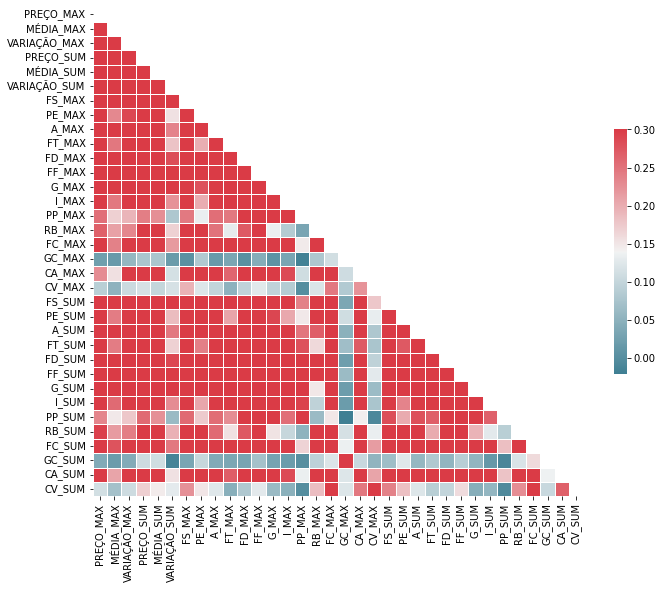

In [12]:
corr = x_.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
);

In [13]:
gc.collect()

15

## seleção

In [14]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=10, n_estimators=500, oob_score=True)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, max_iter=23)

feat_selector.fit(x_.values, yy)

Iteration: 	1 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	2 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	3 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	4 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	5 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	6 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	7 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	8 / 23
Confirmed: 	17
Tentative: 	2
Rejected: 	15
Iteration: 	9 / 23
Confirmed: 	17
Tentative: 	2
Rejected: 	15
Iteration: 	10 / 23
Confirmed: 	17
Tentative: 	2
Rejected: 	15
Iteration: 	11 / 23
Confirmed: 	17
Tentative: 	2
Rejected: 	15
Iteration: 	12 / 23
Confirmed: 	17
Tentative: 	2
Rejected: 	15
Iteration: 	13 / 23
Confirmed: 	17
Tentative: 	2
Rejected: 	15
Iteration: 	14 / 23
Confirmed: 	17
Tentative: 	2
Rejected: 	15
Iteration: 	15 / 23
Confirmed: 	17
Tentative: 	2
Rejected: 	15
Iteration: 	16 / 23
Confirmed: 	17
Tentative: 	2
Rejected: 	15
Iteratio

BorutaPy(estimator=RandomForestClassifier(max_depth=10, n_estimators=61,
                                          n_jobs=-1, oob_score=True,
                                          random_state=RandomState(MT19937) at 0x7F7225FAD740),
         max_iter=23, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F7225FAD740, verbose=2)

In [15]:
accept = x_.columns[feat_selector.support_].to_list()
irresolution = x_.columns[feat_selector.support_weak_].to_list()

In [16]:
xx_ = feat_selector.transform(x_.values)

print('Accepted features:')
print('----------------------------')
print(list(accept))
print('----------------------------')
print(list(irresolution))

Accepted features:
----------------------------
['PREÇO_MAX', 'MÉDIA_MAX', 'VARIAÇÃO_MAX', 'PREÇO_SUM', 'MÉDIA_SUM', 'VARIAÇÃO_SUM', 'FS_MAX', 'FD_MAX', 'FF_MAX', 'G_MAX', 'I_MAX', 'FC_MAX', 'FS_SUM', 'FF_SUM', 'I_SUM', 'FC_SUM', 'CA_SUM']
----------------------------
[]


In [17]:
gc.collect()

216

## modelo

+ $ \theta = \sigma( \alpha + x\beta) $
+ $ y \sim Bern(\theta) $

$$ p = logit\left( \beta_0 + \sum_{c}\beta_{c}X_c\right)$$

In [18]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

for train_index, test_index in skf.split(x_[accept], yy):
    Xt, Xh = x_.iloc[train_index][accept], x_.iloc[test_index][accept]
    yt, yh = yy[train_index], yy[test_index]
    
    print(Xt.shape, Xh.shape, yt.shape, yh.shape)

(855, 17) (428, 17) (855,) (428,)
(855, 17) (428, 17) (855,) (428,)
(856, 17) (427, 17) (856,) (427,)


In [19]:
lower  = -10**6
higher = 10**6

sigma2 = 1.0
b = 1.0 / np.sqrt(2.0 * sigma2)

In [20]:
shape_ = (Xt.shape[1], len(np.unique(yt)))
shape_

(17, 6)

In [21]:
try:
    del model_reglog
except:
    pass

In [22]:
with pm.Model() as model_reglog:    
    alfa = pm.Uniform("alfa", lower=lower, upper=higher, shape=shape_[1] )
    beta = pm.Laplace("beta", mu=0, b=b, shape=shape_)
    
    mu = pm.Deterministic("mu", alfa + pm.math.dot(Xt.values, beta))
    
    p = pm.Deterministic( "p", tt.nnet.softmax(mu) )

In [23]:
with model_reglog:
    observed = pm.Categorical("target", p, observed=yt)
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    n_ = 5000
#     trace = pm.sample(n_, step=step, start=start)
    trace = pm.sample(n_, step=step, start={"alfa":np.zeros(shape_[1]), "beta":np.zeros(shape_)})
    burned_trace = trace[int(0.75 * n_):]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alfa]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [24]:
# pm.traceplot(burned_trace) 
# plt.show()

In [25]:
gc.collect()

39314

In [26]:
pd.DataFrame(burned_trace["beta"].mean(0).T, columns=Xt.columns)

PREÇO_MAX  MÉDIA_MAX  VARIAÇÃO_MAX  PREÇO_SUM  MÉDIA_SUM  VARIAÇÃO_SUM  \
0  -2.344001   0.057591      0.253467  -2.955665  -3.686208      0.652380   
1   0.667351   0.502705      3.015567   2.512411   0.772502     -1.736350   
2  -0.188660   0.060742      0.363611   0.078100   1.437677     -0.673579   
3  -0.150891  -0.719695     -0.389757  -1.866618  -4.103211      0.630031   
4   7.259196  -0.605606     -2.395347   1.055627   0.609708      1.245099   
5   0.174292   0.242352     -0.660414   0.183447   0.541159     -0.404964   

     FS_MAX    FD_MAX    FF_MAX     G_MAX     I_MAX    FC_MAX    FS_SUM  \
0  4.082226  2.890604  6.440912  7.300326  9.379404 -0.024218  0.041738   
1 -0.312014 -1.373549 -1.975542 -1.765044 -0.752696 -7.610170  0.629494   
2  0.518067  0.527447  0.288869 -2.827602  1.180605  6.528345  0.521189   
3  3.506214  5.280213  4.921630  0.662642 -1.138939  5.941728  0.943565   
4 -1.633216 -1.402443 -2.663914 -0.734190 -0.429199 -6.382519 -0.601190   
5 -0.382165 -0.355535  0.425963  0.479100  0.093631  1.243358 -0.333084   

     FF_SUM     I_SUM    FC_SUM    CA_SUM  
0  0.435025 -0.347895  0.106937 -2.092288  
1 -1.319069 -1.196844 -1.181334  1.542119  
2  0.316105  0.579891  0.480688  0.273824  
3 -0.277798 -0.136261  0.436486  0.242018  
4 -0.692064  0.298144 -0.830301 -2.650558  
5  0.079235  0.180710  0.332292  4.460501

In [27]:
pd.DataFrame(burned_trace["alfa"].mean(0).T, columns=["alfa"])

alfa
0  0.201975
1  0.072116
2  0.324441
3  0.972689
4 -0.877734
5  0.861835

In [28]:
y_prob = burned_trace['mu'].mean(0)
y_pred = [ np.exp(pp)/np.sum(np.exp(pp), axis=0) for pp in y_prob ]
y_pred = np.argmax(y_pred, axis=1)

In [29]:
print( classification_report(yt, y_pred) )

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       190
           1       0.83      0.47      0.60        64
           2       0.60      0.20      0.30       134
           3       0.49      0.79      0.61       272
           4       0.72      0.88      0.79        60
           5       0.55      0.34      0.42       136

    accuracy                           0.58       856
   macro avg       0.65      0.56      0.57       856
weighted avg       0.61      0.58      0.56       856



In [30]:
h_pred = burned_trace['alfa'].mean(0) + np.dot(Xh, burned_trace['beta'].mean(0))

In [31]:
h_prob = np.exp(h_pred).T/np.sum(np.exp(h_pred), axis=1)

In [32]:
h_pred = np.argmax(h_prob, axis=0)

In [33]:
print( classification_report(yh, h_pred) )

              precision    recall  f1-score   support

           0       0.70      0.61      0.65        95
           1       0.79      0.47      0.59        32
           2       0.62      0.23      0.33        66
           3       0.51      0.82      0.63       136
           4       0.63      0.71      0.67        31
           5       0.40      0.28      0.33        67

    accuracy                           0.56       427
   macro avg       0.61      0.52      0.53       427
weighted avg       0.58      0.56      0.54       427



In [34]:
perc = .10

display( (pd.DataFrame(h_prob.T) > 1 - perc).sum(axis=1).value_counts() )
print()
display( (pd.DataFrame(h_prob.T) < perc).sum(axis=1).value_counts() )
print()
print(Xh.shape)

0    416
1     11
dtype: int64

3    134
2    104
4     89
1     59
5     26
0     15
dtype: int64


(427, 17)


In [35]:
del model_reglog

In [36]:
gc.collect()

0

- - -

In [118]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [119]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:25]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df:  8.3 MiB
                       gscouts: 532.6 KiB
                             X: 416.1 KiB
                            x_: 340.9 KiB
                            xx: 340.9 KiB
                          gpos: 206.9 KiB
                      gmercado: 191.8 KiB
                            Xt: 120.4 KiB
                            Xh: 60.1 KiB
                        y_prob: 40.2 KiB
                        h_prob: 20.1 KiB
                          corr: 12.3 KiB
                           _93: 10.7 KiB
                           _94: 10.7 KiB
                          _112: 10.7 KiB
                          _113: 10.7 KiB
                           _74: 10.7 KiB
                           _75: 10.7 KiB
                           _86: 10.7 KiB
                           _90: 10.7 KiB
                           _91: 10.7 KiB
                           _92: 10.7 KiB
                           _95: 10.7 KiB
                           _96: 10.7 KiB
         

os ombos de gigantes:

+ [GLM in PyMC3: Out-Of-Sample Predictions — PyMC3 3.11.4 documentation](https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-out-of-sample-predictions.html)
+ [Problem implementing Softmax Regression (Multinomial Logistic) · Issue #1004 · pymc-devs/pymc](https://github.com/pymc-devs/pymc/issues/1004)
+ [Bayesian Linear Regression](https://outline.com/V532t7)
+ [Error with Model: Initial evaluation of model at starting point failed! - Questions - PyMC Discourse](https://discourse.pymc.io/t/error-with-model-initial-evaluation-of-model-at-starting-point-failed/7160)
+ [Shafi's ML Blog: Bayesian Regression using PyMC3](https://shafiab.blogspot.com/2017/12/bayesian-regression-using-pymc3.html#bayesian-prior-ridge-regression)
+ [Prior Distributions for Bayesian Regression Using PyMC | Austin Rochford](https://austinrochford.com/posts/2013-09-02-prior-distributions-for-bayesian-regression-using-pymc.html)

- - -

```
with pm.Model() as second_model: 
    #priors with normal distribution    beta_0=pm.Normal('beta_0', mu=0, sd=10**4)
    beta_temp=pm.Normal('beta_temp', mu=0, sd=10**4)
    beta_humid=pm.Normal('beta_humid', mu=0, sd=10**4)
    beta_light=pm.Normal('beta_light', mu=0, sd=10**4)
    beta_co2=pm.Normal('beta_co2', mu=0, sd=10**4)
    beta_humid_ratio=pm.Normal('beta_humid_ration', mu=0, sd=10**4)    #probability of belonging to class 1    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_temp*df['Temperature']+
                               beta_humid*df['Humidity']+
                               beta_light*df['Light']+
                               beta_co2*df['CO2']+
                               beta_humid_ratio*df['HumidityRatio']))#fit observed data into the modelwith second_model:
    observed=pm.Bernoulli("occupancy", p, observed=df['Occupancy'])
    start=pm.find_MAP()
    step=pm.Metropolis()
    second_trace=pm.sample(25000, step=step, start=start)
    second_burned_trace=second_trace[15000:]
pm.traceplot(second_burned_trace)
plt.show()
```

e

```
with pm.Model() as third_model:
    pm.glm.GLM.from_formula('Occupancy ~ Temperature + Humidity + Light + CO2 + HumidityRatio',
                            df,
                            family=pm.glm.families.Binomial())
    third_trace = pm.sample(25000, tune=10000, init='adapt_diag')pm.traceplot(third_trace)
plt.show()
```

são a mesma coisa praticamente

.